In [1]:
# from expl_bind_vertex_calc import *
# import matplotlib.pyplot as plt
# import matplotlib.patches
# import seaborn as sns

# define $\phi^{(TOT)} $ full implementation

Experimental-based view defining 3 beakers :P

## define system

In [1]:
from expl_bind_beaker_vertex_calc import *
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

In [2]:
n_bind = 2 #types of proteins/marks
# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
# e_m = np.array([0, 0]) #binding energy FOR F_BIND_ALT

# e_m = np.array([2, 2]) #binding energy FOR F_BIND_ALT


v_int =  np.array([[-4, 4], [4, -4]])
# phi_s = 
M = 50
bs_per_M = 10 # binding sites per averarged monomer M
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]


v_s = 1
v_p = 1
v_A = v_p
v_B = v_p
N_P = 5000
# N_A = 1 # point particle limit
N_A = 50 # macromolecule
N_B = N_A
b_P = 1
b_A = b_P
b_B = b_P

#orig
# V = 1
# V_p = 4*V
# V_A = V_B = V#*0.86#05

V = 1
V_p = 4*V
V_A = V_B = V#*0.86#05
# phi_p_i = 1
phi_p_i = 0.9
# phi_p_i = 0.7
# phi_p_i = 0.5
phi_a_i = np.arange(0,1.01,0.1)
phi_b_i = np.arange(0,1.01,0.1)

# OLD
# chi_AB_phi_p_N = 20 # nice for macromolecule limit
# chi_AB_phi_p_N = 20000 # nice for point particle limit


# chi_AB = 0.00857 # macromolecules w 1 binding site per M
# chi_AB = 0.006666 # macromolecules w 1 binding site per M
# chi_AB = 13.33/25

# chi_AB = .00857 * 1000 # point particle limit w 1 binding site per M

chi_AB = 10 / (N_A) # macromol and point! works for phi^(U)_alpha **2 and other def
# chi_AB = 50 / (N_A*5) # macromol 
# chi_AB = 50 / (N_A*N_P)**0.5 #macromol 

# chi_AB = .00857 * 2500 # point particle limit w 100 binding sites per M
# chi_AB = .00857 * 2500/50 # macromolecule limit w 100 binding sites per M


psol = Polymer_soln(n_bind, v_int, e_m, phi_p_i, phi_a_i, phi_b_i, V_p, V_A, V_B, poly_marks,\
                  v_s, v_p, v_A, v_B, N_P, N_A, N_B, b_P, b_A, b_B, chi_AB, bs_per_M)
# psol = Polymer_soln(n_bind, v_int, e_m, phi_p, phi_s, \
#                     poly_marks, v_s, v_p, v_A, v_B, N_P, N_A, N_B,
#                     b_P, b_A, b_B, chi_AB)

In [3]:
# res_factor = 350
# print("res_factor: ", res_factor)
# phi_a_i_fine = np.arange(0.1, 1 + 0.1 / res_factor, 0.1 / res_factor)
# phi_b_i_fine = np.arange(0.1, 1 + 0.1 / res_factor, 0.1 / res_factor)


# for i in range(len(phi_a_i_fine)):
#     for j in range(len(phi_b_i_fine)):
#         continue

In [14]:
# len(phi_a_i_fine)

In [ ]:
# chi_AB = 50 / (N_A*5)

In [ ]:
# (N_A*5)

In [ ]:
# (N_A*N_P)**0.5

In [3]:
phi_p_f, phi_a_f, phi_b_f, phi_s, phi_Au_mat, phi_Ab_mat, \
phi_Bu_mat, phi_Bb_mat, mu_A_mat, mu_B_mat, fA_mat, fB_mat, f0_mat, sA_mat, sB_mat = calc_mu_phi_bind(psol,)

In [7]:
# trues = np.sum(np.round(sA_mat,3) == np.round(np.einsum("ijk -> jik", sB_mat[:,:,::-1]),3))
# np.size(sA_mat)/trues

In [8]:
# np.round(mu_A_mat,4) == np.round(mu_B_mat.T,4)

In [51]:
# chi_AB = chi_AB_phi_p_N / (N_P * phi_p_f)
chi_AB

1.0

In [14]:
# mu_A_mat

In [16]:
# phi_s

In [18]:
ID_number = chi_AB + phi_p_i + N_A + N_P + V_p + V_A + e_m[0] + M + res_factor*10 + bs_per_M


params_dic = {"M":M, "e_m":e_m, "v_s=v_pv_A=v_B": v_s,\
              "N_P":N_P, "N_A = N_B":N_A, "b_P = b_A = b_B":b_P,\
              "Beaker V_P":V_p, "beaker V_A, V_B":V_A, "phi_p_i":phi_p_i, \
              "phi_a_i=phi_b_i":phi_a_i, "chi_AB": chi_AB,\
             "psol": psol, "phi_p_f":phi_p_f, "del_phi_a_i":del_phi_a_i, \
                "res_factor" : res_factor, "bs_per_M": bs_per_M, "ID_number": ID_number}

5107.42857


In [20]:
phi_p_f

0.6

## $\phi, \mu, f_\alpha $ plotting

### $\phi$

Text(0.5, 49.7222222222222, '$\\phi_B^{(i)}$')

<Figure size 640x480 with 0 Axes>

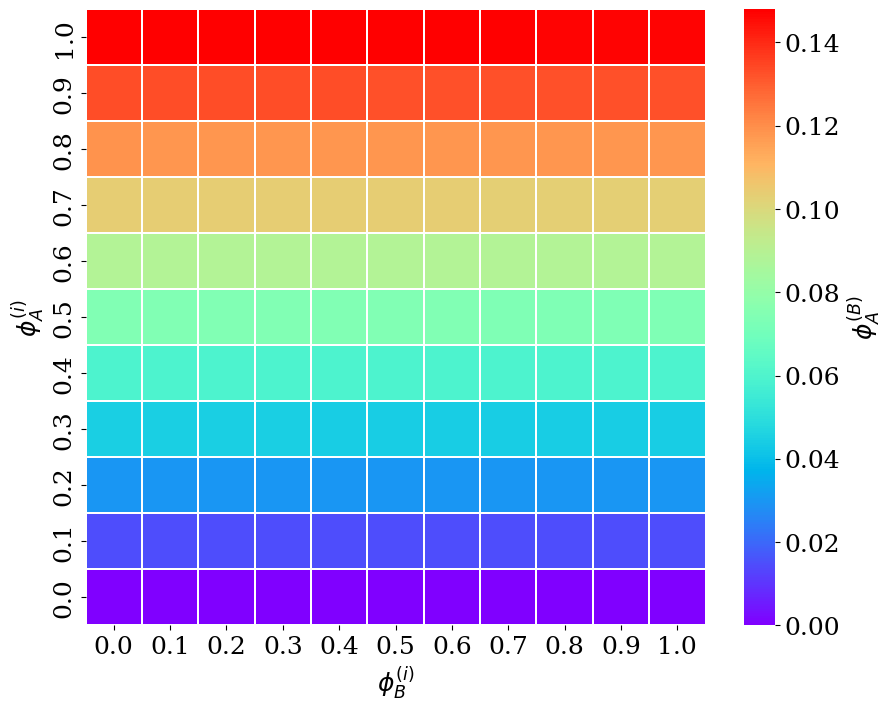

In [419]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("INVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_A^{(f)} = \phi_A^{(TOT)}$"}, vmin=0, vmax=1)
# ax = sns.heatmap(phi_b_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_B^{(f)} = \phi_B^{(TOT)}$"}, vmin=0, vmax=1)
# ax = sns.heatmap(phi_Au_mat, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_A^{(U)}$"})
ax = sns.heatmap(phi_Ab_mat, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
                 cbar_kws={'label':  r"$\phi_A^{(B)}$"})
# ax = sns.heatmap(phi_s, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_S$"}, vmin=0, vmax=1)
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
# plt.title(r"$\phi_A^{(f)} = \phi_A^{(TOT)}$") 

# plt.savefig('OABS_phases.png')

Text(0.5, 49.7222222222222, '$\\phi_B^{(i)}$')

<Figure size 640x480 with 0 Axes>

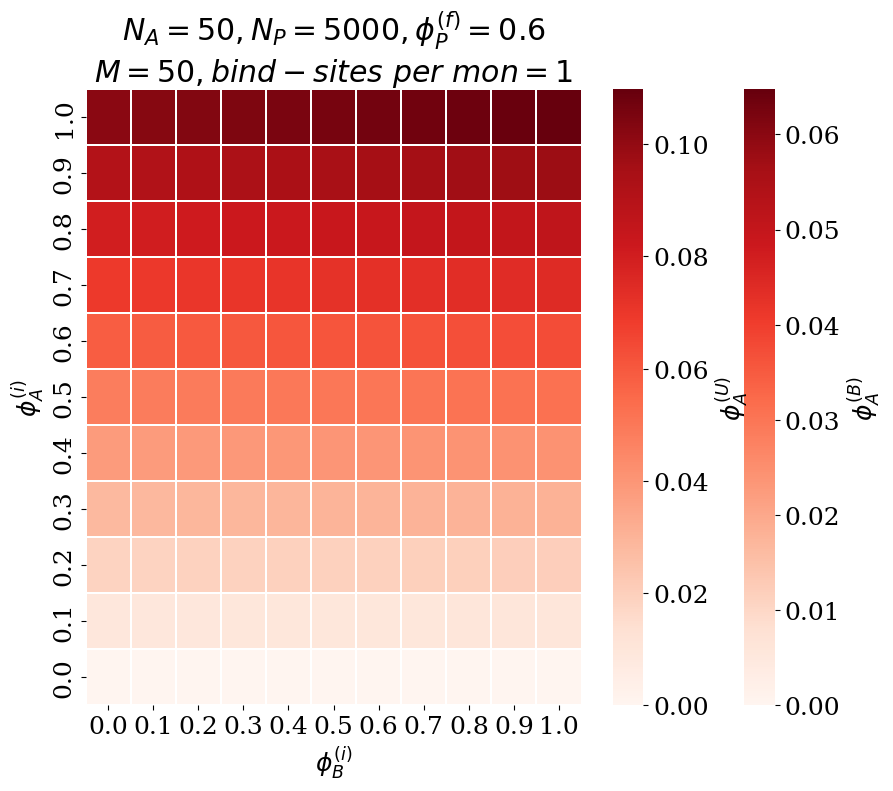

In [53]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ax = sns.heatmap(phi_Ab_mat, linewidth=0.25, cmap = "Reds", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
                 cbar_kws={'label':  r"$\phi_A^{(B)}$"})
ax = sns.heatmap(phi_Au_mat, linewidth=0.25, cmap = "Reds", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
                 cbar_kws={'label':  r"$\phi_A^{(U)}$"})
# ax = sns.heatmap(phi_Bb_mat, linewidth=0.25, cmap = "Blues", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_B^{(B)}$"})
# ax = sns.heatmap(phi_Bb_mat, linewidth=0.25, cmap = "Blues", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_B^{(U)}$"})

ax.invert_yaxis()
# plt.title("$\phi_P^{(f)} = %s$" % phi_p_f)
plt.title(r"$ N_A = %s, N_P = %s, \phi_P^{(f)} = %s $" % (N_A, N_P, phi_p_f)  + "\n" + r"$ M = %s, bind-sites \ per \ mon = %s $" % ( M, bs_per_M))

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")


Text(0.5, 49.7222222222222, '$\\phi_B^{(i)}$')

<Figure size 640x480 with 0 Axes>

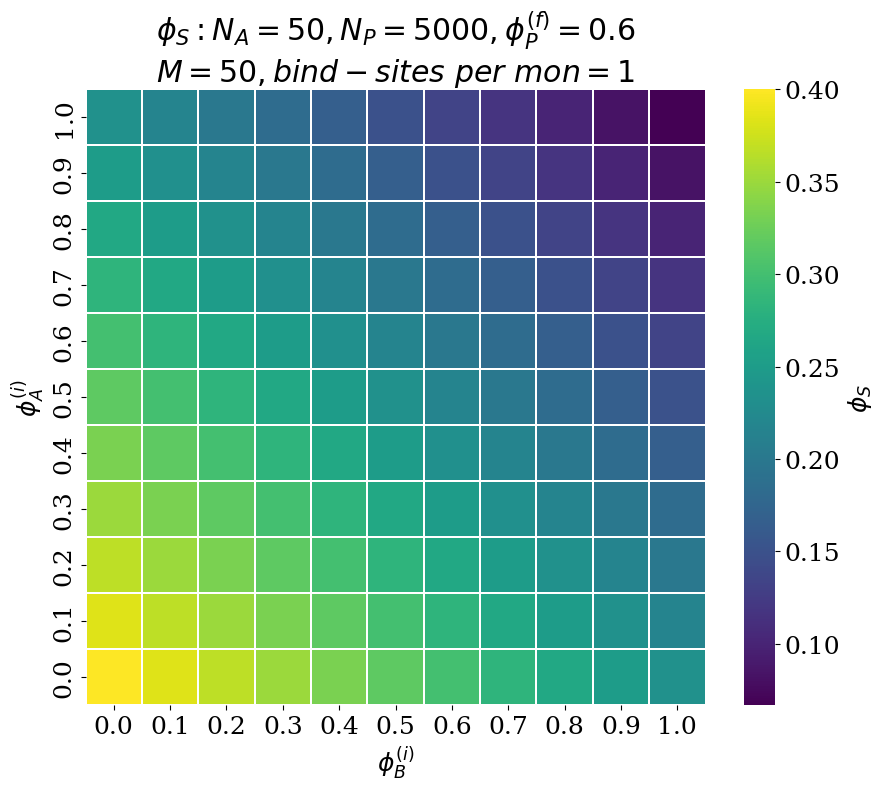

In [440]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ax = sns.heatmap(phi_s, linewidth=0.25, cmap = "viridis", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
                 cbar_kws={'label':  r"$\phi_S$"})
# ax = sns.heatmap(phi_Au_mat, linewidth=0.25, cmap = "Reds", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_A^{(U)}$"})
# ax = sns.heatmap(phi_Bb_mat, linewidth=0.25, cmap = "Blues", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_B^{(B)}$"})
# ax = sns.heatmap(phi_Bb_mat, linewidth=0.25, cmap = "Blues", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_B^{(U)}$"})

ax.invert_yaxis()
# plt.title("$\phi_P^{(f)} = %s$" % phi_p_f)
plt.title(r"$ \phi_S: N_A = %s, N_P = %s, \phi_P^{(f)} = %s $" % (N_A, N_P, phi_p_f) + "\n" + r"$ M = %s, bind-sites \ per \ mon = %s $" % ( M, bs_per_M)) 

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")


Text(0.5, 49.7222222222222, '$\\phi_B^{(i)}$')

<Figure size 640x480 with 0 Axes>

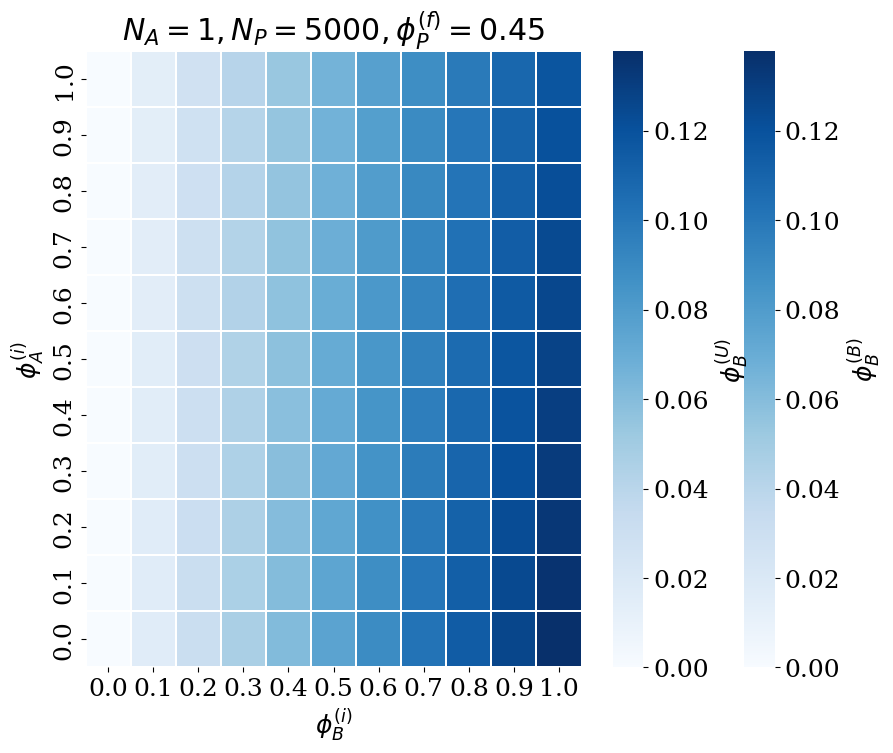

In [96]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_Ab_mat, linewidth=0.25, cmap = "Reds", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_A^{(B)}$"})
# ax = sns.heatmap(phi_Au_mat, linewidth=0.25, cmap = "Reds", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
#                  cbar_kws={'label':  r"$\phi_A^{(U)}$"})
ax = sns.heatmap(phi_Bb_mat, linewidth=0.25, cmap = "Blues", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
                 cbar_kws={'label':  r"$\phi_B^{(B)}$"})
ax = sns.heatmap(phi_Bb_mat, linewidth=0.25, cmap = "Blues", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
                 cbar_kws={'label':  r"$\phi_B^{(U)}$"})

ax.invert_yaxis()
plt.title(r"$ N_A = %s, N_P = %s, \phi_P^{(f)} = %s $" % (N_A, N_P, phi_p_f)) 
plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")


### $\mu$

Text(0.5, 1.0, '$\\mu_A$\n$ M = 50, bind-sites \\ per \\ mon = 1 $')

<Figure size 640x480 with 0 Axes>

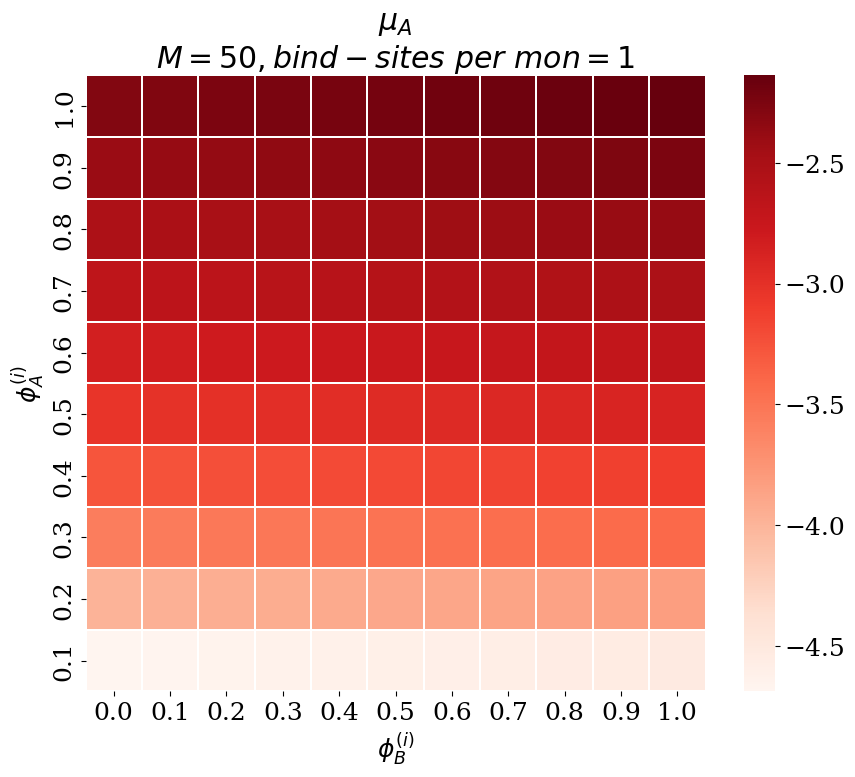

In [442]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
#                  cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=1)
ax = sns.heatmap(mu_A_mat[1:,:], linewidth=0.25, cmap = "Reds", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i[1:], 2))
                 # cbar_kws={'label':  r"$\phi$"})
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$\mu_A$" + "\n" + r"$ M = %s, bind-sites \ per \ mon = %s $" % ( M, bs_per_M)) 

# plt.savefig('OABS_phases.png')

Text(0.5, 1.0, '$\\mu_B$')

<Figure size 640x480 with 0 Axes>

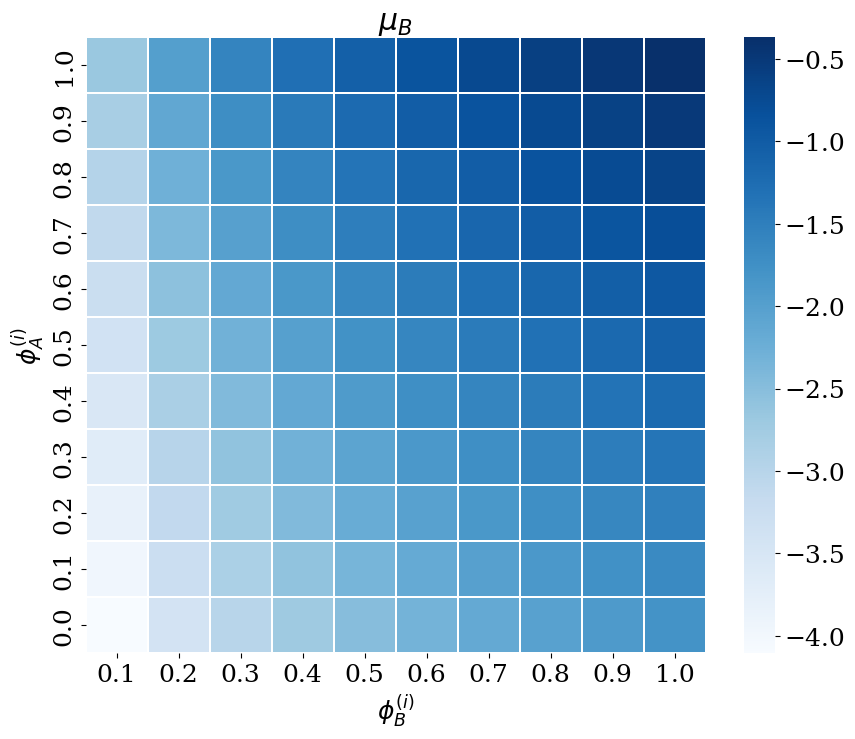

In [15]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
#                  cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=1)
ax = sns.heatmap(mu_B_mat[:,1:], linewidth=0.25, cmap = "Blues", xticklabels=np.round(phi_b_i[1:], 2), yticklabels=np.round(phi_a_i, 2))
                 # cbar_kws={'label':  r"$\phi$"})
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$\mu_B$") 

# plt.savefig('OABS_phases.png')

### $f_A$

Text(0.5, 1.0, '$f_B, \\phi_p^{(f)} = 0.6$\n$ M = 50, bind-sites \\ per \\ mon = 10 $')

<Figure size 640x480 with 0 Axes>

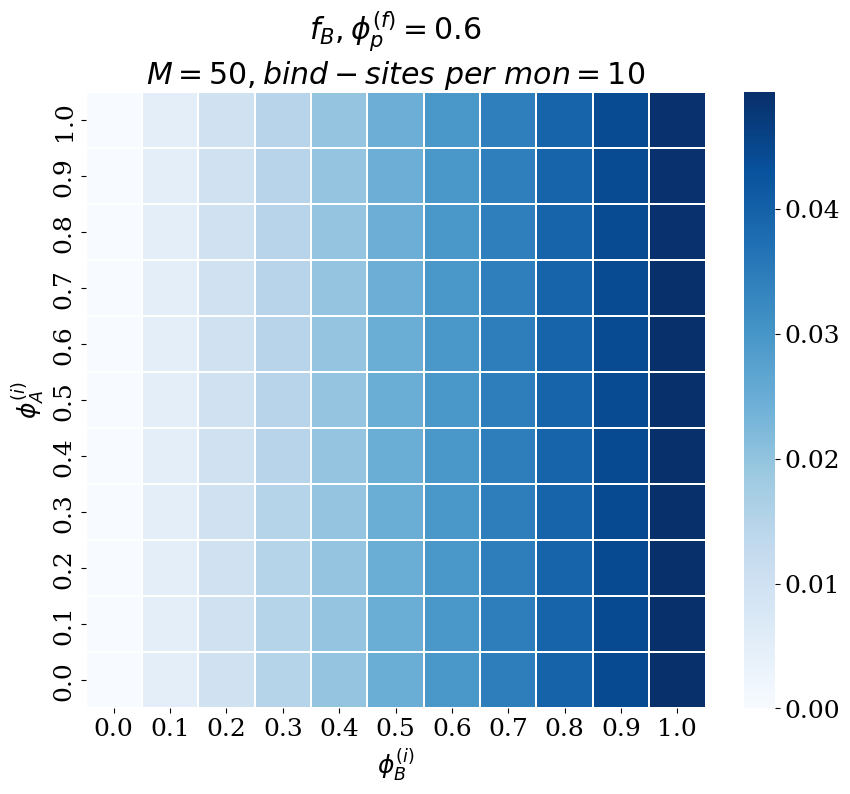

In [8]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
#                  cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=1)
ax = sns.heatmap(fB_mat[:,:], linewidth=0.25, cmap = "Blues", xticklabels=np.round(phi_b_i[:], 2), yticklabels=np.round(phi_a_i, 2))
                 # cbar_kws={'label':  r"$\phi$"})
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$f_B, \phi_p^{(f)} = %s$" % phi_p_f  + "\n" + r"$ M = %s, bind-sites \ per \ mon = %s $" % ( M, bs_per_M))  

# plt.savefig('OABS_phases.png')

Text(0.5, 1.0, '$f_A$')

<Figure size 640x480 with 0 Axes>

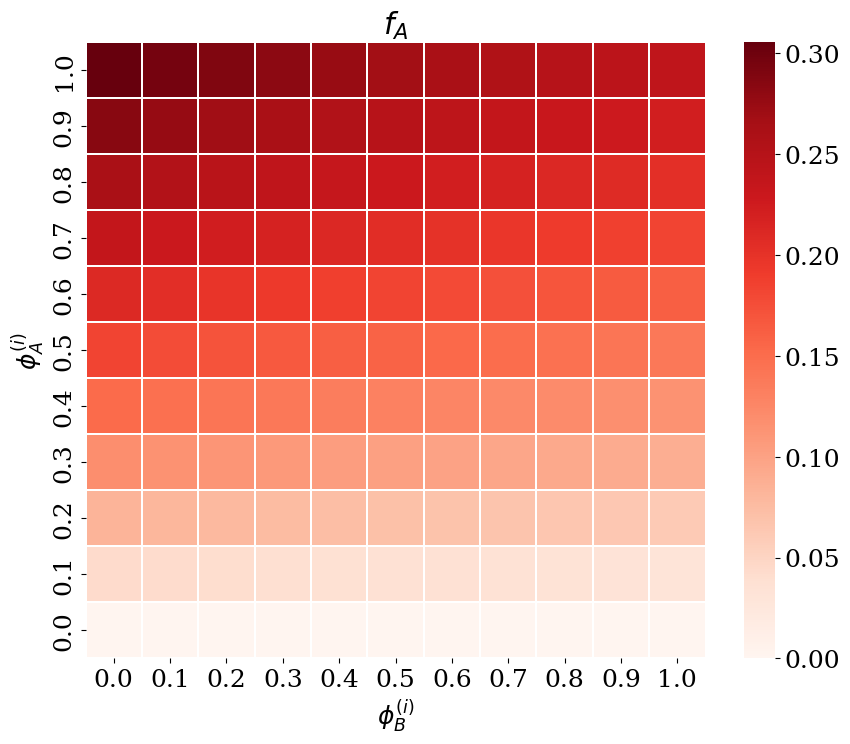

In [17]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
#                  cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=1)
ax = sns.heatmap(fA_mat[:,:], linewidth=0.25, cmap = "Reds", xticklabels=np.round(phi_b_i[:], 2), yticklabels=np.round(phi_a_i[:], 2))
                 # cbar_kws={'label':  r"$\phi$"})
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$f_A$") 

# plt.savefig('OABS_phases.png')

### heatmap TODO

In [18]:
# # Plot 1: heatmap on top-left
# import matplotlib.pyplot as plt
# import seaborn as sns
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import matplotlib.patches as patches

# mu2_array = np.round(mu2_arr,2)
# mu1_array = np.round(mu1_arr,2)

# # fig, ax = plt.subplots(figsize=(4, 5))
# ax = ax1

# vmin=0
# vmax=1
# # First heatmap
# hm1 = sns.heatmap(fB_mat, linewidth=0.0, cmap=blue_cmap,
#                   xticklabels=mu2_array, yticklabels=mu1_array,
#                   cbar=False, square=True, ax=ax, vmin=vmin, vmax=vmax, rasterized=True)
# # pos = ax.get_position()  # get the position of the axes in figure coordinates
# # rect = patches.Rectangle((pos.x0, pos.y0), pos.width, pos.height,
# #                          linewidth=1.5, edgecolor='black', facecolor='none',
# #                          transform=fig.transFigure, zorder=10)

# # fig.patches.append(rect)

# # Manually add colorbar 1
# cax1 = inset_axes(ax, width="100%", height="5%", loc='upper right',
#                   bbox_to_anchor=(-0., 0.1, 1, 1),  # adjust right position with 1.05
#                   bbox_transform=ax.transAxes, borderpad=0)

# cb1 = fig.colorbar(hm1.collections[0], cax=cax1, orientation='horizontal', ticks=[0,  1])

# # cb1.set_label(r'$ \langle f_B \rangle $')
# cb1.outline.set_edgecolor('black')
# cb1.outline.set_linewidth(1.5)
# cb1.ax.xaxis.set_ticks_position('top')
# cb1.ax.xaxis.set_label_position('top')

# cb1.ax.text(.4, 1.25, r'$ \langle f_B \rangle $',
#             transform=cb1.ax.transAxes,
#             fontsize=fontsize, ha='left', va='bottom')
# # # Manually add colorbar 1
# # cax1 = inset_axes(ax, width="5%", height="50%", loc='upper left',
# #                   bbox_to_anchor=(1, 0.1, 1, 1),  # adjust left/right with -0.15
# #                   bbox_transform=ax.transAxes, borderpad=0)

# # cb1 = fig.colorbar(hm2.collections[0], cax=cax1)
# # cb1.set_label(r'$ \langle f_B \rangle $')
# # cb1.outline.set_edgecolor('black')
# # cb1.outline.set_linewidth(1.5)

# # Second heatmap (overlayed)
# hm2 = sns.heatmap(fA_mat, linewidth=0.0, cmap=red_cmap,
#                   xticklabels=np.round(mu2_array, 3), yticklabels=np.round(mu1_array,3),
#                   cbar=False, square=True, ax=ax, vmin=vmin, vmax=vmax, rasterized=True)

# # # Manually add colorbar 2
# # cax2 = inset_axes(ax, width="100%", height="5%", loc='upper right',
# #                   bbox_to_anchor=(-0., 0.1, 1, 1),  # adjust right position with 1.05
# #                   bbox_transform=ax.transAxes, borderpad=0)

# # cb2 = fig.colorbar(hm2.collections[-1], cax=cax2, orientation='horizontal')
# # cb2.set_label(r'$ \langle f_A \rangle $')
# # cb2.outline.set_edgecolor('black')
# # cb2.outline.set_linewidth(1.5)


# # Manually add colorbar 2
# cax2 = inset_axes(ax, width="5%", height="100%", loc='upper left',
#                   bbox_to_anchor=(1.05, 0.0, 1, 1),  # adjust left/right with -0.15
#                   bbox_transform=ax.transAxes, borderpad=0)

# cb2 = fig.colorbar(hm2.collections[-1], cax=cax2, ticks=[0, 1])
# # cb2.set_label(r'$ \langle f_A \rangle $')
# cb2.outline.set_edgecolor('black')
# cb2.outline.set_linewidth(1.5)
# cb2.ax.text(1.08, 0.55, r'$ \langle f_A \rangle $',
#             transform=cb2.ax.transAxes,
#             fontsize=fontsize, ha='left', va='top', rotation=0)




# # ax.scatter(10,10, marker = "*")
# # ax.scatter(10,10, marker = "*")
# hm1.invert_yaxis()

# hm1.set_ylabel("$\mu_A$")
# hm1.set_xlabel("$\mu_B$")



# # plt.tight_layout()
# # plt.show()

## spinodal

In [79]:
# phi_p_f, phi_a_f, phi_b_f, phi_s, phi_Au_mat, phi_Ab_mat, \
# phi_Bu_mat, phi_Bb_mat, mu_A_mat, mu_B_mat, fA_mat, fB_mat, f0_mat = calc_mu_phi_bind(psol,)

In [4]:
klog_min = -2.5
klog_max = -1.69 # = np.log10(1/N_A)
klog_num = 10

k_vec = np.logspace(klog_min, klog_max, klog_num) / b_P

In [9]:
chi_AP = 0
chi_BP = 0
# chi_AB = 69.5 / (phi_p*N_P) 
chi_PS = 0
chi_AS = 0
chi_BS = 0

# chis = [chi_AP, chi_BP, chi_AB, chi_PS, chi_AS, chi_BS]


min_eigval_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(phi_a_i[:]), len(phi_b_i[:])))
min_eigval_arr_allk_ps = np.zeros((len(phi_a_i[:]), len(phi_b_i[:])))

# min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 5))
# min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 5))
min_eigvec_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), 3))
k_star_arr_DENS= np.zeros((len(phi_a_i[:]), len(phi_b_i[:])))# - 4

cond_num_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), len(k_vec)))
max_cond_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:])))

for i in range(len(phi_a_i)):
    for j in range(len(phi_b_i)):

        # assym spinodal- ANSWER: numerical instabilities when defining vertex functions with a component that has volfrac = 0
        # skip = True
        # if i == 0 and j == 7:
        #     skip = False
        # elif j == 0 and i == 7:
        #     skip = False
        # if skip:
        #     continue
        
#         if mu1 == mu2:
#             continue
        # mu = [mu1, mu2]
        # print("mu: ", mu)
        
        s_bnd_A = sA_mat[i,j]
        s_bnd_B = sB_mat[i,j]

        phi_Au = phi_Au_mat[i,j]
        phi_Bu = phi_Bu_mat[i,j]
        phi_sf = phi_s[i,j]


        #---------------------------- EQUIVALENCE TEST_---------------------------
        # s_bnd_A = sA_mat[i,j]
        # s_bnd_B = sA_mat[j,i][::-1]

        # phi_Au = phi_Au_mat[i,j]
        # phi_Bu = phi_Au_mat[j,i]
        # phi_sf = phi_s[i,j]
        #---------------------------- EQUIVALENCE TEST_---------------------------

        

        phis = [phi_p_f, phi_Au, phi_Bu, phi_sf]
        # if i == 0 and j == len(phi_Au_arr)-1:
        #     print("SA: ", s_bnd_A)
        #     print("SB: ", s_bnd_B)
        for ik, k in enumerate(k_vec):
            # if ik != 0:
            #     continue
            # print(k)

            # s_bnd_A = s_bind_A_ALL[i, j]
            # s_bnd_B = s_bind_B_ALL[i, j]

            # M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            # S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            # cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, phis, k)

            # print(G2)
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            # print(val)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        # print("----------")
        # print("ij: ", i, j)
        # print("min_vals", min_vals)
        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        # print("minvals all k: ", minval_allk)
        # print(np.where(min_vals==minval_allk)[0])
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        if len(np.where(min_vals==minval_allk)[0]) == 1:
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]
            k_star = k_vec[np.where(min_vals==minval_allk)]
        else: #if mulitple minimum eigenvalues, just choose the first one (0) or last (-1)
            # print("ARB")
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)][-1,:]
            k_star = k_vec[np.where(min_vals==minval_allk)][-1]

            # min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)][0,:]
            # k_star = k_vec[np.where(min_vals==minval_allk)][0]
        
        k_star_arr_DENS[i][j] = k_star

        # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

In [10]:
spinodal = np.copy(k_star_arr_DENS)
spinodal[np.where(spinodal == k_vec[0])] = 0 # macro
spinodal[np.where(spinodal > k_vec[0])] = 1 # micro

In [11]:
spinodal

array([[-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

Text(0.5, 1.0, '$spinodal, N_A = 50, N_P = 5000, \\phi_P^{(f)} = 0.6, \\chi_{AB} = 0.2, $\n$ M = 50, bind-sites \\ per \\ mon = 10 , \\epsilon_B = 1.52$')

<Figure size 640x480 with 0 Axes>

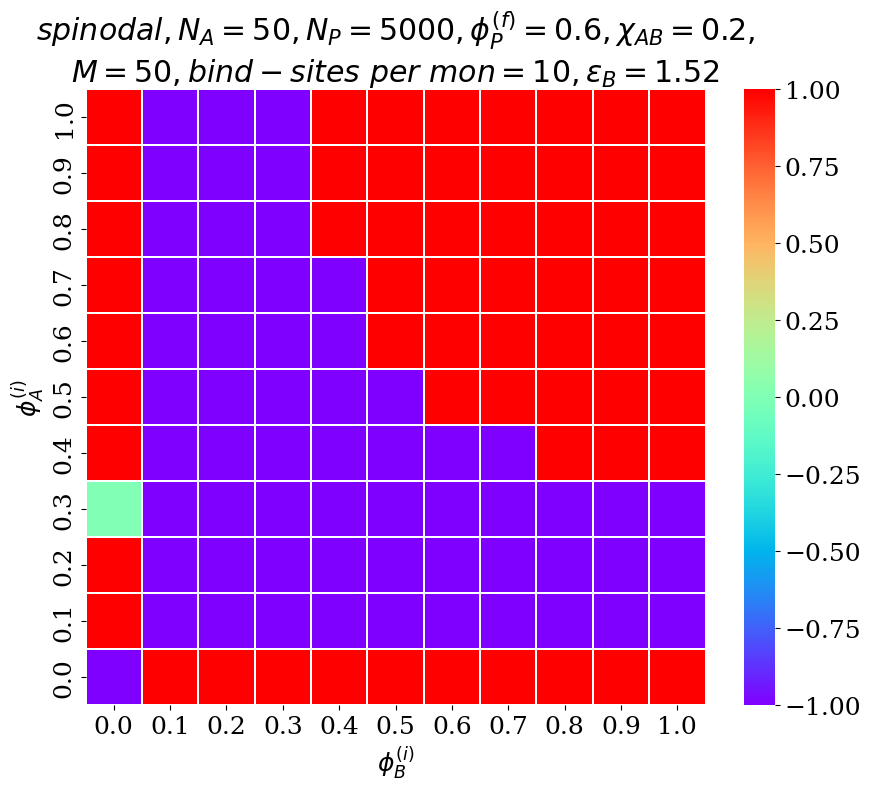

In [12]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
#                  cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=1)
ax = sns.heatmap(spinodal, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(phi_b_i[:], 2), yticklabels=np.round(phi_a_i[:], 2),\
                 vmin=-1, vmax=1)# cbar_kws={'label':  r"$\phi$"})
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$spinodal, N_A = %s, N_P = %s, \phi_P^{(f)} = %s, \chi_{AB} = %s, $"% (N_A, N_P, phi_p_f, chi_AB,) + "\n" + r"$ M = %s, bind-sites \ per \ mon = %s , \epsilon_B = %s$" % ( M, bs_per_M, e_m[0])) 

# plt.savefig('OABS_phases.png')

### boundary finder

In [29]:
spinodal[1:,1:]

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.],
       [-1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [41]:
# len(np.arange(0.1,1+0.1/res_factor,0.1/res_factor))
# 

In [30]:
%%time
import numpy as np
from scipy.spatial import cKDTree

mat_coarse = spinodal[1:, 1:]
res_factor = 10

phi_a_i_fine = np.arange(0.1, 1 + 0.1 / res_factor, 0.1 / res_factor)
phi_b_i_fine = np.arange(0.1, 1 + 0.1 / res_factor, 0.1 / res_factor)
mat_fine = np.zeros((len(phi_a_i_fine), len(phi_b_i_fine)))

x_min, x_max = 0.1, 1.0
y_min, y_max = 0.1, 1.0

n, m = mat_coarse.shape[0], mat_fine.shape[0]

x_coarse = np.linspace(x_min, x_max, n)
y_coarse = np.linspace(y_min, y_max, n)
x_fine = np.linspace(x_min, x_max, m)
y_fine = np.linspace(y_min, y_max, m)

Xc, Yc = np.meshgrid(x_coarse, y_coarse)
Xf, Yf = np.meshgrid(x_fine, y_fine)

# --- Find boundaries between 1 and -1 ---
edges_x = np.abs(np.diff(mat_coarse, axis=1)) > 0
edges_y = np.abs(np.diff(mat_coarse, axis=0)) > 0

# --- Compute midpoints of edges instead of corners ---
# horizontal boundaries (between cols)
bx = (Xc[:, :-1][edges_x] + Xc[:, 1:][edges_x]) / 2
by = (Yc[:, :-1][edges_x] + Yc[:, 1:][edges_x]) / 2

# vertical boundaries (between rows)
bx2 = (Xc[:-1, :][edges_y] + Xc[1:, :][edges_y]) / 2
by2 = (Yc[:-1, :][edges_y] + Yc[1:, :][edges_y]) / 2

# Combine boundary coordinates
boundary_coords = np.column_stack([
    np.concatenate([bx, bx2]),
    np.concatenate([by, by2])
])

# look at fine points near boundary
fine_points = np.column_stack([Xf.ravel(), Yf.ravel()])

tree = cKDTree(boundary_coords)
# dist_thresh = (x_max - x_min) / (res_factor*2)
dist_thresh = (x_max - x_min) / n  * 0.75  # half–one coarse cell width works best

idxs = tree.query_ball_point(fine_points, r=dist_thresh)
near_boundary = np.array([len(i) > 0 for i in idxs]).reshape(m, m)
# near_boundary = np.array([len(i) == (res_factor-1) for i in idxs]).reshape(m, m)


mat_fine[near_boundary] = 1


CPU times: total: 0 ns
Wall time: 12.3 ms


### start: more efficient boundary finder and fine stability analysis

In [17]:
%%time
# more efficnet naygpt

mat_coarse = spinodal[1:, 1:]
res_factor = 10

phi_a_i_fine = np.arange(0.1, 1 + 0.1 / res_factor, 0.1 / res_factor)
phi_b_i_fine = np.arange(0.1, 1 + 0.1 / res_factor, 0.1 / res_factor)
mat_fine = np.zeros((len(phi_a_i_fine), len(phi_b_i_fine)))

x_min, x_max = 0.1, 1.0
y_min, y_max = 0.1, 1.0

n, m = mat_coarse.shape[0], mat_fine.shape[0]

x_coarse = np.linspace(x_min, x_max, n)
y_coarse = np.linspace(y_min, y_max, n)
x_fine = np.linspace(x_min, x_max, m)
y_fine = np.linspace(y_min, y_max, m)

Xc, Yc = np.meshgrid(x_coarse, y_coarse)
Xf, Yf = np.meshgrid(x_fine, y_fine)

# --- Find boundaries between 1 and -1 ---
edges_x = np.abs(np.diff(mat_coarse, axis=1)) > 0
edges_y = np.abs(np.diff(mat_coarse, axis=0)) > 0

boundary_coarse = np.zeros_like(mat_coarse, bool)
boundary_coarse[:, :-1] |= edges_x
boundary_coarse[:-1, :] |= edges_y

from scipy.ndimage import zoom, distance_transform_edt

# scale factor between coarse and fine
scale = len(phi_a_i_fine) / mat_coarse.shape[0]

# upsample the coarse boundary to fine grid
boundary_fine0 = zoom(boundary_coarse.astype(float), scale, order=1)

# threshold to get clean boolean mask
boundary_fine = boundary_fine0 > 0.1

# distance (in fine-pixel units) from nearest boundary pixel
dist = distance_transform_edt(~boundary_fine)

# choose thickness of band (fine pixels)
band_thickness = 2      # or 1, 3, 5 … depending on refinement needs
near_boundary = dist <= band_thickness

mat_fine[near_boundary] = 1

i_idx, j_idx = np.where(near_boundary)

# corresponding coordinates
phiA_list = phi_a_i_fine[i_idx]
phiB_list = phi_b_i_fine[j_idx]


CPU times: total: 0 ns
Wall time: 8.74 ms


In [21]:
np.shape(phi_a_i_fine)

(91,)

In [94]:
np.shape(near_boundary)

(91, 91)

In [66]:
# results = np.zeros_like(near_boundary, dtype=int)

# for k, (a, b) in enumerate(zip(phiA_list, phiB_list)):
#     # run your microphase evaluation here
#     # (gamma2/gamma3 minimizing root finder, etc.)

#     sep = microphase_test(a, b)    # <-- your function

#     if sep:
#         i = i_idx[k]
#         j = j_idx[k]
#         results[i, j] = 1

In [80]:
# from collections import defaultdict

# # group fine-grid boundary points by row index
# row_points = defaultdict(list)
# for ii, jj in zip(i_idx, j_idx):
#     row_points[ii].append(jj)

# # OPTIONAL: sort columns in each row so scanning is left → right
# for r in row_points:
#     row_points[r].sort()

# # results = np.zeros_like(near_boundary, dtype=int)
# # ISSUE: how can i skip a row if not organized in rows?? dont want all points calculated
# # SOLUTION: this, sorted points by row
# for row in sorted(row_points.keys()):
#     for col in row_points[row]:
#         # compute the two fine variables
#         print(row)
        
#         # a = phi_a_i_fine[row]
#         # b = phi_b_i_fine[col]

#         # # your heavy computation
#         # if microphase_test(a, b):
#         #     results[row, col] = 1
#         #     break      # <-- early exit for this row

In [23]:
%%time
# Recalculate all quantities wrt this fine-grained diagram

psol_fine = Polymer_soln(n_bind, v_int, e_m, phi_p_i, phi_a_i_fine, phi_b_i_fine, V_p, V_A, V_B, poly_marks,\
                  v_s, v_p, v_A, v_B, N_P, N_A, N_B, b_P, b_A, b_B, chi_AB, bs_per_M)


phi_p_f, phi_a_f, phi_b_f, phi_s, phi_Au_mat, phi_Ab_mat, \
phi_Bu_mat, phi_Bb_mat, mu_A_mat, mu_B_mat, fA_mat, fB_mat, f0_mat, sA_mat, sB_mat = calc_mu_phi_bind(psol_fine,)


phi_a_i = phi_a_i_fine
phi_b_i = phi_b_i_fine


chi_AP = 0
chi_BP = 0
# chi_AB = 69.5 / (phi_p*N_P) 
chi_PS = 0
chi_AS = 0
chi_BS = 0


# chis = [chi_AP, chi_BP, chi_AB, chi_PS, chi_AS, chi_BS]

min_eigval_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(phi_a_i[:]), len(phi_b_i[:])))
min_eigval_arr_allk_ps = np.zeros((len(phi_a_i[:]), len(phi_b_i[:])))

# min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 5))
# min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 5))
min_eigvec_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), 3))
k_star_arr_DENS= np.zeros((len(phi_a_i[:]), len(phi_b_i[:]))) 

cond_num_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), len(k_vec)))
max_cond_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:])))

# for i in range(len(phi_a_i)):
#     for j in range(len(phi_b_i)):
for k, (a, b) in enumerate(zip(phiA_list, phiB_list)):
        # if mat_fine[i,j] == 0:
        #     continue# NEW LINES
    i = i_idx[k]
    j = j_idx[k]
    s_bnd_A = sA_mat[i,j]
    s_bnd_B = sB_mat[i,j]

    phi_Au = phi_Au_mat[i,j]
    phi_Bu = phi_Bu_mat[i,j]
    phi_sf = phi_s[i,j]

    phis = [phi_p_f, phi_Au, phi_Bu, phi_sf]

    for ik, k in enumerate(k_vec):
        G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, phis, k)
        val, vec = np.linalg.eigh(G2)
        vec = vec.T
        min_val = np.min(val)            
        min_eigval_arr[i][j][ik] = min_val
        min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

    # all-k analysis
    # min eigvals, eigvecs at given mu1,mu2 for each k        
    min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
    min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]

    # minimum eigenvalue at given mu1,mu2 across all ks
    minval_allk = np.min(min_vals) 
    
    # store this eigenvalue and corresponding eigenvector
    min_eigval_arr_allk_DENS[i][j] = minval_allk 
    if len(np.where(min_vals==minval_allk)[0]) == 1:
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]
        k_star = k_vec[np.where(min_vals==minval_allk)]
    else: #if mulitple minimum eigenvalues, just choose the first one (0) or last (-1)
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)][-1,:]
        k_star = k_vec[np.where(min_vals==minval_allk)][-1]

    k_star_arr_DENS[i][j] = k_star

    # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
    # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0
# 
print("fine stability analysis finished")


poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

spinodal = np.copy(k_star_arr_DENS)
spinodal[np.where(spinodal == k_vec[0])] = 0 # macro
spinodal[np.where(spinodal > k_vec[0])] = 1 # micro

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

#-------------------------------------------------------------------------------------------------
# BOUNDARY phase calculation
#------------------------------------------------------------------------------------------------
phases = np.zeros((len(phi_a_i_fine), len(phi_b_i_fine))) - 1 
minF_arr = np.zeros((len(phi_a_i_fine), len(phi_b_i_fine)))

from collections import defaultdict

# group fine-grid boundary points by row index
row_points = defaultdict(list)
for ii, jj in zip(i_idx, j_idx):
    row_points[ii].append(jj)

# OPTIONAL: sort columns in each row so scanning is left → right
for r in row_points:
    row_points[r].sort()

# results = np.zeros_like(near_boundary, dtype=int)
# ISSUE: how can i skip a row if not organized in rows?? dont want all points calculated
# SOLUTION: this, sorted points by row
for i in sorted(row_points.keys()):
    real_phase_calc = False # only want a single phase calc in the boundary
    for j in row_points[i]:
        if real_phase_calc == True:
            continue
        # compute the two fine variables
        # a = phi_a_i_fine[row]
        # b = phi_b_i_fine[col]

        # # your heavy computation
        # if microphase_test(a, b):
        #     results[row, col] = 1
        #     break      # <-- early exit for this row


# for i in range(len(phi_a_i_fine)):
#     real_phase_calc = False # only want a single phase calc in the boundary
#     for j in range(len(phi_b_i_fine)):
#         if real_phase_calc == True:
#             continue
#         if mat_fine[i,j] == 0:
#             continue

        # print("mu: ", mu1, mu2)
        q_star = k_star_arr_DENS[i,j]
        vec_star = min_eigvec_arr_allk_DENS[i,j]
        
        phi_sf = phi_s[i,j]
        phi_Au = phi_Au_mat[i,j]
        phi_Bu = phi_Bu_mat[i,j]
        # phi_Ab = phi_Ab_mat[i,j]
        # phi_Bb = phi_Bu_mat[i,j]
 
        phis = [phi_p_f, phi_Au, phi_Bu, phi_sf]
                        
        if q_star == -1:
            print("out of spinodal; no q_star")
            phases[i,j] = 0 # disordered phase- outside of spinodal
        elif q_star == k_vec[0]:
        # elif q_star != k_vec[-1]:
            print("macrophase sep")
            phases[i,j] = 1 # macrophase sep

        else: #microphse sep
            print("microsep")
            s_bnd_A = sA_mat[i,j,:]#s_bind_A_ALL[i,j,:]
            s_bnd_B = sB_mat[i,j,:]#s_bind_B_ALL[i,j,:]
    
            lam_q = q_star*np.array([1, 0, 0])
            lam_q = np.linalg.norm(lam_q)
    
            cyl_q1 = q_star*np.array([1, 0, 0])
            # cyl_q1 = np.linalg.norm(cyl_q1)
            cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
            # cyl_q2 = np.linalg.norm(cyl_q2)
            cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
            # cyl_q3 = np.linalg.norm(cyl_q3)
            cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
            
            bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
            bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
            bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
            bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
            bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
            bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
            
            
            lam_g3 = 0
            G3 = gamma3(psol, s_bnd_A, s_bnd_B, phis, cyl_qs) # all g3s are eqivlaent
            cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
            bcc_g3 = (4/(3*np.sqrt(6))) * G3
            
            G4_00 = gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([lam_q, -lam_q, lam_q, -lam_q]))
            lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
            
            cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
              72*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
            
            bcc_g4 = (1/24)* (G4_00 \
                     + 8*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
                     + 2*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
                     + 4*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
    
            lam_g2 = (1/2) * 2 * (1) * gamma2_chis(psol, s_bnd_A, s_bnd_B, phis, q_star)
            cyl_g2 = lam_g2
            bcc_g2 = lam_g2

            print("made it to crit fluc")            
            # CRITICAL FLUCTIATION
            # define a lambda scalar value for a given critica lfluctutaion, then use roots equation to find cirtical points, and eval F at each
            lam_lambda_2 = np.einsum("ij,i,j ->", lam_g2, vec_star, vec_star)
            lam_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -lam_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_l_amps = np.real(np.roots([4*lam_lambda_4,0,2*lam_lambda_2,0]))        
            lamF = min(np.real( lam_lambda_2 * pos_l_amps**2 + lam_lambda_4 * pos_l_amps**4))
    
            
            cyl_lambda_2 = np.einsum("ij,i,j ->", cyl_g2, vec_star, vec_star)
            cyl_lambda_3 = np.einsum("ijk,i,j,k->", cyl_g3, vec_star, vec_star, vec_star)
            cyl_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -cyl_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_c_amps = np.real(np.roots([4*cyl_lambda_4,3*cyl_lambda_3,2*cyl_lambda_2,0]))        
            cylF = min(np.real( cyl_lambda_2 * pos_c_amps**2 + cyl_lambda_3*pos_c_amps**3 + cyl_lambda_4 * pos_c_amps**4))
    
            
            bcc_lambda_2 = np.einsum("ij,i,j ->", bcc_g2, vec_star, vec_star)
            bcc_lambda_3 = np.einsum("ijk,i,j,k->", bcc_g3, vec_star, vec_star, vec_star)
            bcc_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -bcc_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_b_amps = np.real(np.roots([4*bcc_lambda_4,3*bcc_lambda_3,2*bcc_lambda_2,0]))        
            bccF = min(np.real( bcc_lambda_2 * pos_b_amps**2 + bcc_lambda_3*pos_b_amps**3 + bcc_lambda_4 * pos_b_amps**4))        



            minF = np.min([lamF, cylF, bccF, 0])
            minF_arr[i,j] = minF
            # print("--------------------------------------------------------------------")
            # print("energies:")
            print([lamF, cylF, bccF, 0])

            if minF == 0:
                # raise Exception("phase sep not stable in spinodal??")
                phases[i,j] = -2
            elif minF == lamF:
                phases[i,j] = 2
            elif minF == cylF:
                phases[i,j] = 3
            elif minF == bccF:
                phases[i,j] = 4
            real_phase_calc = True

fine stability analysis finished
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_

KeyboardInterrupt: 

### end of more eff code

In [58]:
# for i in idxs:
#     if len(i) > 0:
#         print(len(i))

In [60]:
# mat_coarse.shape[0]

In [62]:
# mat_fine

Text(0.5, 1.0, '$spinodal, N_A = 50, N_P = 5000, \\phi_P^{(f)} = 0.6, \\chi_{AB} = 0.2 $')

<Figure size 640x480 with 0 Axes>

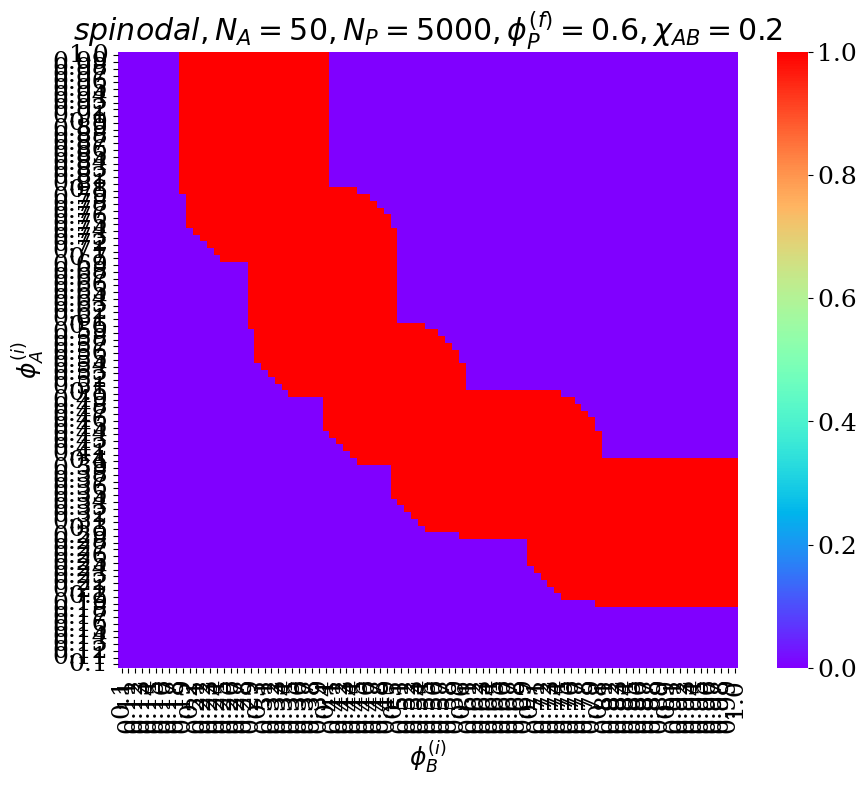

In [19]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
#                  cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=1)
ax = sns.heatmap(mat_fine, linewidth=0., cmap = "rainbow", xticklabels=np.round(phi_a_i_fine[:], 2), yticklabels=np.round(phi_a_i_fine[:], 2))
                 # cbar_kws={'label':  r"$\phi$"})
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$spinodal, N_A = %s, N_P = %s, \phi_P^{(f)} = %s, \chi_{AB} = %s $" % (N_A, N_P, phi_p_f, chi_AB)) 

# plt.savefig('OABS_phases.png')

In [30]:
# Recalculate all quantities wrt this fine-grained diagram

psol_fine = Polymer_soln(n_bind, v_int, e_m, phi_p_i, phi_a_i_fine, phi_b_i_fine, V_p, V_A, V_B, poly_marks,\
                  v_s, v_p, v_A, v_B, N_P, N_A, N_B, b_P, b_A, b_B, chi_AB)


phi_p_f, phi_a_f, phi_b_f, phi_s, phi_Au_mat, phi_Ab_mat, \
phi_Bu_mat, phi_Bb_mat, mu_A_mat, mu_B_mat, fA_mat, fB_mat, f0_mat, sA_mat, sB_mat = calc_mu_phi_bind(psol_fine,)


phi_a_i = phi_a_i_fine
phi_b_i = phi_b_i_fine


chi_AP = 0
chi_BP = 0
# chi_AB = 69.5 / (phi_p*N_P) 
chi_PS = 0
chi_AS = 0
chi_BS = 0


# chis = [chi_AP, chi_BP, chi_AB, chi_PS, chi_AS, chi_BS]

min_eigval_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(phi_a_i[:]), len(phi_b_i[:])))
min_eigval_arr_allk_ps = np.zeros((len(phi_a_i[:]), len(phi_b_i[:])))

# min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 5))
# min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 5))
min_eigvec_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), 3))
k_star_arr_DENS= np.zeros((len(phi_a_i[:]), len(phi_b_i[:]))) 

cond_num_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:]), len(k_vec)))
max_cond_arr = np.zeros((len(phi_a_i[:]), len(phi_b_i[:])))

for i in range(len(phi_a_i)):
    for j in range(len(phi_b_i)):
        if mat_fine[i,j] == 0:
            continue# NEW LINES
#         if mu1 == mu2:
#             continue
        # mu = [mu1, mu2]
        # print("mu: ", mu)
        s_bnd_A = sA_mat[i,j]
        s_bnd_B = sB_mat[i,j]

        phi_Au = phi_Au_mat[i,j]
        phi_Bu = phi_Bu_mat[i,j]
        phi_sf = phi_s[i,j]

        phis = [phi_p_f, phi_Au, phi_Bu, phi_sf]
        # if i == 0 and j == len(phi_Au_arr)-1:
        #     print("SA: ", s_bnd_A)
        #     print("SB: ", s_bnd_B)
        for ik, k in enumerate(k_vec):

            # print(k)

            # s_bnd_A = s_bind_A_ALL[i, j]
            # s_bnd_B = s_bind_B_ALL[i, j]

            # M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            # S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            # cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, phis, k)

            # print(G2)
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            # print(val)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]

        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        if len(np.where(min_vals==minval_allk)[0]) == 1:
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]
            k_star = k_vec[np.where(min_vals==minval_allk)]
        else: #if mulitple minimum eigenvalues, just choose the first one (0) or last (-1)
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)][-1,:]
            k_star = k_vec[np.where(min_vals==minval_allk)][-1]

        k_star_arr_DENS[i][j] = k_star

        # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0
# 
print("coarse stability analysis finished")


poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

spinodal = np.copy(k_star_arr_DENS)
spinodal[np.where(spinodal == k_vec[0])] = 0 # macro
spinodal[np.where(spinodal > k_vec[0])] = 1 # micro

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

#-------------------------------------------------------------------------------------------------
# BOUNDARY phase calculation
#------------------------------------------------------------------------------------------------
phases = np.zeros((len(phi_a_i_fine), len(phi_b_i_fine))) - 1 
minF_arr = np.zeros((len(phi_a_i_fine), len(phi_b_i_fine)))



for i in range(len(phi_a_i_fine)):
    real_phase_calc = False # only want a single phase calc in the boundary
    for j in range(len(phi_b_i_fine)):
        if real_phase_calc == True:
            continue
        if mat_fine[i,j] == 0:
            continue
        # if i == 0 or j == 0: # was for getting rid of phi_a_i =0, but no
            # continue

        # if i != mu1_i:
        #     continue
        # if j != mu2_j:
        #     continue

        # print("mu: ", mu1, mu2)
        q_star = k_star_arr_DENS[i,j]
        vec_star = min_eigvec_arr_allk_DENS[i,j]
        
        phi_sf = phi_s[i,j]
        phi_Au = phi_Au_mat[i,j]
        phi_Bu = phi_Bu_mat[i,j]
        # phi_Ab = phi_Ab_mat[i,j]
        # phi_Bb = phi_Bu_mat[i,j]
 
        phis = [phi_p_f, phi_Au, phi_Bu, phi_sf]
                        
        if q_star == -1:
            print("out of spinodal; no q_star")
            phases[i,j] = 0 # disordered phase- outside of spinodal
        elif q_star == k_vec[0]:
        # elif q_star != k_vec[-1]:
            print("macrophase sep")
            phases[i,j] = 1 # macrophase sep

        else: #microphse sep
        
            s_bnd_A = sA_mat[i,j,:]#s_bind_A_ALL[i,j,:]
            s_bnd_B = sB_mat[i,j,:]#s_bind_B_ALL[i,j,:]
    
            lam_q = q_star*np.array([1, 0, 0])
            lam_q = np.linalg.norm(lam_q)
    
            cyl_q1 = q_star*np.array([1, 0, 0])
            # cyl_q1 = np.linalg.norm(cyl_q1)
            cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
            # cyl_q2 = np.linalg.norm(cyl_q2)
            cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
            # cyl_q3 = np.linalg.norm(cyl_q3)
            cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
            
            bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
            bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
            bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
            bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
            bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
            bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
            
            
            lam_g3 = 0
            G3 = gamma3(psol, s_bnd_A, s_bnd_B, phis, cyl_qs) # all g3s are eqivlaent
            cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
            bcc_g3 = (4/(3*np.sqrt(6))) * G3
            
            G4_00 = gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([lam_q, -lam_q, lam_q, -lam_q]))
            lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
            
            cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
              72*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
            
            bcc_g4 = (1/24)* (G4_00 \
                     + 8*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
                     + 2*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
                     + 4*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
    
            lam_g2 = (1/2) * 2 * (1) * gamma2_chis(psol, s_bnd_A, s_bnd_B, phis, q_star)
            cyl_g2 = lam_g2
            bcc_g2 = lam_g2

            # # # PHYSICALLY BOUNDED AMPLITUDE
            # # del_phi = phi - phi_0. phi goes from 0 to phi_p. therefore del_phi(max) = phi_p-phi_0 ; del_phi(min) = - phi_0
            # # need to use a sigmoid (goes 0 to 1) then del_phi = phi_p * sigmoid(amps) - phi_0 ; phi_0 = [f_O, f_A, f_B]
            # # raise Exception("NNED to implement phi right----- look below :D")
            # phi_0 = phi_p * np.array([fo_mat[0][0], fa_mat[0][0], fb_mat[0][0]])
            # initial = [0, 0, 0] # poly, A, B
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                                 phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # lamF_q = res.fun
            
            # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    #  + np.einsum("ijk,i,j,k ->", cyl_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    # +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # cylF_q = 1000000000#res.fun

            # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    #  + np.einsum("ijk,i,j,k ->", bcc_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    # +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # bccF_q = 1000000000#res.fun          



            print("made it to crit fluc")            
            # CRITICAL FLUCTIATION
            # define a lambda scalar value for a given critica lfluctutaion, then use roots equation to find cirtical points, and eval F at each
            lam_lambda_2 = np.einsum("ij,i,j ->", lam_g2, vec_star, vec_star)
            lam_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -lam_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_l_amps = np.real(np.roots([4*lam_lambda_4,0,2*lam_lambda_2,0]))        
            lamF = min(np.real( lam_lambda_2 * pos_l_amps**2 + lam_lambda_4 * pos_l_amps**4))
    
            
            cyl_lambda_2 = np.einsum("ij,i,j ->", cyl_g2, vec_star, vec_star)
            cyl_lambda_3 = np.einsum("ijk,i,j,k->", cyl_g3, vec_star, vec_star, vec_star)
            cyl_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -cyl_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_c_amps = np.real(np.roots([4*cyl_lambda_4,3*cyl_lambda_3,2*cyl_lambda_2,0]))        
            cylF = min(np.real( cyl_lambda_2 * pos_c_amps**2 + cyl_lambda_3*pos_c_amps**3 + cyl_lambda_4 * pos_c_amps**4))
    
            
            bcc_lambda_2 = np.einsum("ij,i,j ->", bcc_g2, vec_star, vec_star)
            bcc_lambda_3 = np.einsum("ijk,i,j,k->", bcc_g3, vec_star, vec_star, vec_star)
            bcc_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -bcc_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_b_amps = np.real(np.roots([4*bcc_lambda_4,3*bcc_lambda_3,2*bcc_lambda_2,0]))        
            bccF = min(np.real( bcc_lambda_2 * pos_b_amps**2 + bcc_lambda_3*pos_b_amps**3 + bcc_lambda_4 * pos_b_amps**4))        


            

            # # # BASINHOPPING UNRESTRICTED works at low chi
        
            # initial = [0, 0, 0] # poly, A, B
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, amps, amps, amps, amps)), initial)
            # lamF_q = res.fun
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
            #                                     + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4, amps, amps, amps, amps)), initial)
            # cylF_q = res.fun
    
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
            #                                     + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4, amps, amps, amps, amps)), initial)
            # bccF_q = res.fun            


            
            minF = np.min([lamF, cylF, bccF, 0])
            minF_arr[i,j] = minF
            # print("--------------------------------------------------------------------")
            # print("energies:")
            print([lamF, cylF, bccF, 0])
            # print("--------------------------------------------------------------------")

            # # print([lamF])
            # # print([lamF, cylF])#, bccF])
            if minF == 0:
                # raise Exception("phase sep not stable in spinodal??")
                phases[i,j] = -2
            elif minF == lamF:
                phases[i,j] = 2
            elif minF == cylF:
                phases[i,j] = 3
            elif minF == bccF:
                phases[i,j] = 4
            real_phase_calc = True

coarse stability analysis finished
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no 

KeyboardInterrupt: 

## phase calc

In [96]:
for i in range(5):
    if i == 2:
        pass
    print(i)

0
1
2
3
4


In [34]:
k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

phases = np.zeros((len(phi_a_i), len(phi_b_i))) - 1 
minF_arr = np.zeros((len(phi_a_i), len(phi_b_i)))

for i in range(len(phi_a_i)):
    for j in range(len(phi_b_i)):
        if i == 0 or j == 0:
            continue

        # if i != mu1_i:
        #     continue
        # if j != mu2_j:
        #     continue

        # print("mu: ", mu1, mu2)
        q_star = k_star_arr_DENS[i,j]
        vec_star = min_eigvec_arr_allk_DENS[i,j]
        
        phi_sf = phi_s[i,j]
        phi_Au = phi_Au_mat[i,j]
        phi_Bu = phi_Bu_mat[i,j]
        # phi_Ab = phi_Ab_mat[i,j]
        # phi_Bb = phi_Bu_mat[i,j]
 
        phis = [phi_p_f, phi_Au, phi_Bu, phi_sf]
                
        # TODO- define phis
        
        if q_star == -1:
            print("out of spinodal; no q_star")
            phases[i,j] = 0 # disordered phase- outside of spinodal
        elif q_star == k_vec[0]:
        # elif q_star != k_vec[-1]:
            print("macrophase sep")
            phases[i,j] = 1 # macrophase sep

        else: #microphse sep
        
            s_bnd_A = sA_mat[i,j,:]#s_bind_A_ALL[i,j,:]
            s_bnd_B = sB_mat[i,j,:]#s_bind_B_ALL[i,j,:]
    
            lam_q = q_star*np.array([1, 0, 0])
            lam_q = np.linalg.norm(lam_q)
    
            cyl_q1 = q_star*np.array([1, 0, 0])
            # cyl_q1 = np.linalg.norm(cyl_q1)
            cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
            # cyl_q2 = np.linalg.norm(cyl_q2)
            cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
            # cyl_q3 = np.linalg.norm(cyl_q3)
            cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
            
            bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
            bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
            bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
            bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
            bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
            bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
            
            
            lam_g3 = 0
            G3 = gamma3(psol, s_bnd_A, s_bnd_B, phis, cyl_qs) # all g3s are eqivlaent
            cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
            bcc_g3 = (4/(3*np.sqrt(6))) * G3
            
            G4_00 = gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([lam_q, -lam_q, lam_q, -lam_q]))
            lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
            
            cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
              72*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
            
            bcc_g4 = (1/24)* (G4_00 \
                     + 8*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
                     + 2*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
                     + 4*gamma4(psol, s_bnd_A, s_bnd_B, phis, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
    
            lam_g2 = (1/2) * 2 * (1) * gamma2_chis(psol, s_bnd_A, s_bnd_B, phis, q_star)
            cyl_g2 = lam_g2
            bcc_g2 = lam_g2

            # # # PHYSICALLY BOUNDED AMPLITUDE
            # # del_phi = phi - phi_0. phi goes from 0 to phi_p. therefore del_phi(max) = phi_p-phi_0 ; del_phi(min) = - phi_0
            # # need to use a sigmoid (goes 0 to 1) then del_phi = phi_p * sigmoid(amps) - phi_0 ; phi_0 = [f_O, f_A, f_B]
            # # raise Exception("NNED to implement phi right----- look below :D")
            # phi_0 = phi_p * np.array([fo_mat[0][0], fa_mat[0][0], fb_mat[0][0]])
            # initial = [0, 0, 0] # poly, A, B
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                                 phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # lamF_q = res.fun
            
            # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    #  + np.einsum("ijk,i,j,k ->", cyl_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    # +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # cylF_q = 1000000000#res.fun

            # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    #  + np.einsum("ijk,i,j,k ->", bcc_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    # +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # bccF_q = 1000000000#res.fun          




            print("made it to crit fluc")            
            # CRITICAL FLUCTIATION
            # define a lambda scalar value for a given critica lfluctutaion, then use roots equation to find cirtical points, and eval F at each
            lam_lambda_2 = np.einsum("ij,i,j ->", lam_g2, vec_star, vec_star)
            lam_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -lam_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_l_amps = np.real(np.roots([4*lam_lambda_4,0,2*lam_lambda_2,0]))        
            lamF = min(np.real( lam_lambda_2 * pos_l_amps**2 + lam_lambda_4 * pos_l_amps**4))
    
            
            cyl_lambda_2 = np.einsum("ij,i,j ->", cyl_g2, vec_star, vec_star)
            cyl_lambda_3 = np.einsum("ijk,i,j,k->", cyl_g3, vec_star, vec_star, vec_star)
            cyl_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -cyl_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_c_amps = np.real(np.roots([4*cyl_lambda_4,3*cyl_lambda_3,2*cyl_lambda_2,0]))        
            cylF = min(np.real( cyl_lambda_2 * pos_c_amps**2 + cyl_lambda_3*pos_c_amps**3 + cyl_lambda_4 * pos_c_amps**4))
    
            
            bcc_lambda_2 = np.einsum("ij,i,j ->", bcc_g2, vec_star, vec_star)
            bcc_lambda_3 = np.einsum("ijk,i,j,k->", bcc_g3, vec_star, vec_star, vec_star)
            bcc_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -bcc_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_b_amps = np.real(np.roots([4*bcc_lambda_4,3*bcc_lambda_3,2*bcc_lambda_2,0]))        
            bccF = min(np.real( bcc_lambda_2 * pos_b_amps**2 + bcc_lambda_3*pos_b_amps**3 + bcc_lambda_4 * pos_b_amps**4))        


            

            # # # BASINHOPPING UNRESTRICTED works at low chi
        
            # initial = [0, 0, 0] # poly, A, B
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, amps, amps, amps, amps)), initial)
            # lamF_q = res.fun
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
            #                                     + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4, amps, amps, amps, amps)), initial)
            # cylF_q = res.fun
    
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
            #                                     + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4, amps, amps, amps, amps)), initial)
            # bccF_q = res.fun            


            
            minF = np.min([lamF, cylF, bccF, 0])
            minF_arr[i,j] = minF
            # print("--------------------------------------------------------------------")
            # print("energies:")
            print([lamF, cylF, bccF, 0])
            # print("--------------------------------------------------------------------")

            # # print([lamF])
            # # print([lamF, cylF])#, bccF])
            if minF == 0:
                # raise Exception("phase sep not stable in spinodal??")
                phases[i,j] = -2
            elif minF == lamF:
                phases[i,j] = 2
            elif minF == cylF:
                phases[i,j] = 3
            elif minF == bccF:
                phases[i,j] = 4

        np.save("expl_bind_beaker_rework_minF_em="+str(e_m[0]), minF_arr)
        np.save("expl_bind_beaker_rework_phases_em="+str(e_m[0]), phases)
            

out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
o

KeyboardInterrupt: 

In [ ]:
phases

In [ ]:
# phases = np.load("expl_bind_beaker_phases_em=1.52.npy")

In [ ]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
#                  cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=1)
ax = sns.heatmap(phases[1:,1:], linewidth=0.25, cmap = "viridis", xticklabels=np.round(phi_b_i[1:], 2), yticklabels=np.round(phi_a_i[1:], 2))
                 # cbar_kws={'label':  r"$\phi$"})
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$phases$") 

# plt.savefig('OABS_phases.png')

# OLD $\phi^{(TOT)}$ implementation

## volume fractions

In [3]:
V = 1
v_p = 4*V
v_a = v_b = V 
phi_p_i = 0.9
phi_a_i = np.arange(0,1.01,0.1)
phi_b_i = np.arange(0,1.01,0.1)

phi_p_f = (v_p * phi_p_i) / (v_p + v_a + v_b)

phi_a_f = np.zeros((len(phi_a_i),len(phi_b_i))) - 1
phi_b_f = np.zeros((len(phi_a_i),len(phi_b_i))) - 1
phi_s = np.zeros((len(phi_a_i),len(phi_b_i))) - 1
phi_tot = np.zeros((len(phi_a_i),len(phi_b_i))) - 1
for i in range(len(phi_a_i)):
    for j in range(len(phi_b_i)):
        phiai = phi_a_i[i]
        phibi = phi_b_i[j]

        phiaf = (v_a * phiai) / (v_p + v_a + v_b)
        phibf = (v_b * phibi) / (v_p + v_a + v_b)
        phi_a_f[i,j] = phiaf
        phi_b_f[i,j] = phibf
        phi_s[i,j] = 1 - phi_p_f - phiaf - phibf

# phi_a_f = (v_a * phi_a_i) / (v_p + v_a + v_b)
# phi_b_f = (v_b * phi_b_i) / (v_p + v_a + v_b)

Text(0.5, 1.0, '$\\phi_A^{(f)} = \\phi_A^{(TOT)}$')

<Figure size 640x480 with 0 Axes>

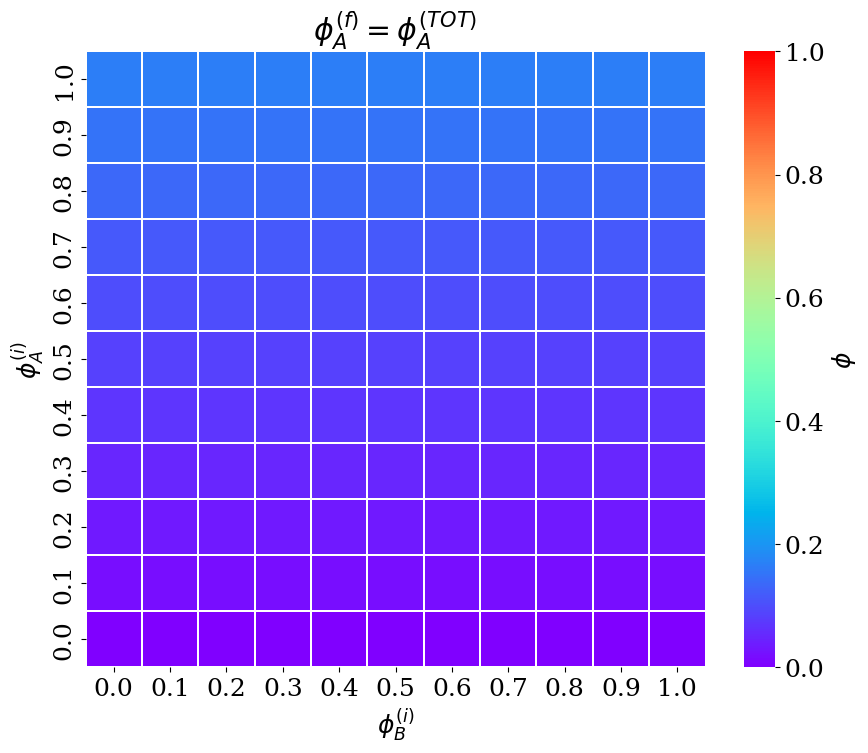

In [5]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
#                  cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=1)
ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
                 cbar_kws={'label':  r"$\phi$"}, vmin=0, vmax=1)
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$\phi_A^{(f)} = \phi_A^{(TOT)}$") 

# plt.savefig('OABS_phases.png')

Text(0.5, 1.0, '$\\phi_B^{(f)} = \\phi_B^{(TOT)}$')

<Figure size 640x480 with 0 Axes>

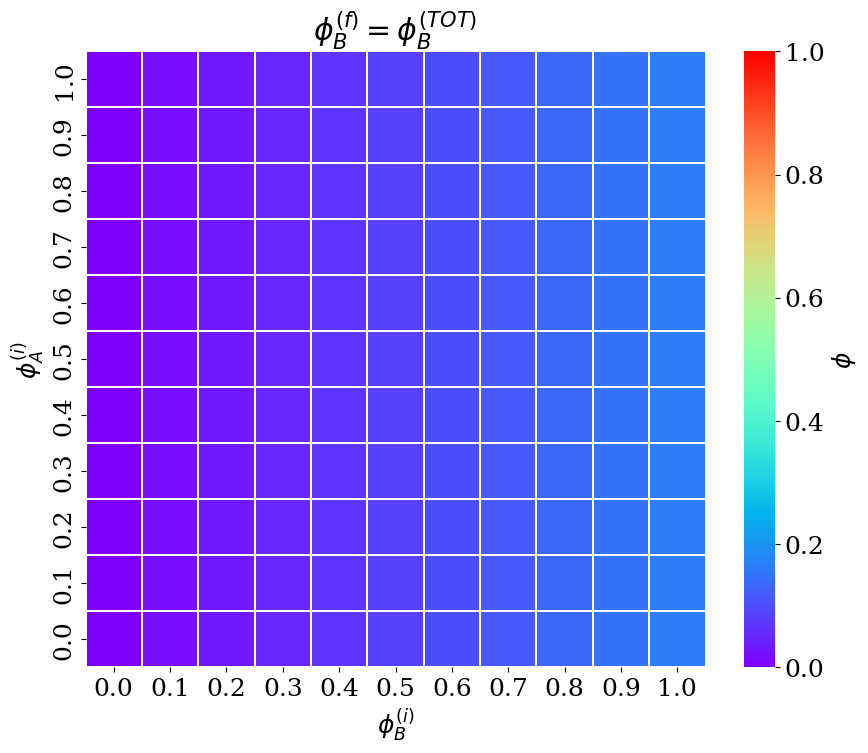

In [6]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
#                  cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=1)
ax = sns.heatmap(phi_b_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
                 cbar_kws={'label':  r"$\phi$"}, vmin=0, vmax=1)
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$\phi_B^{(f)} = \phi_B^{(TOT)}$") 

# plt.savefig('OABS_phases.png')

Text(0.5, 1.0, '$\\phi_S^{(f)}$')

<Figure size 640x480 with 0 Axes>

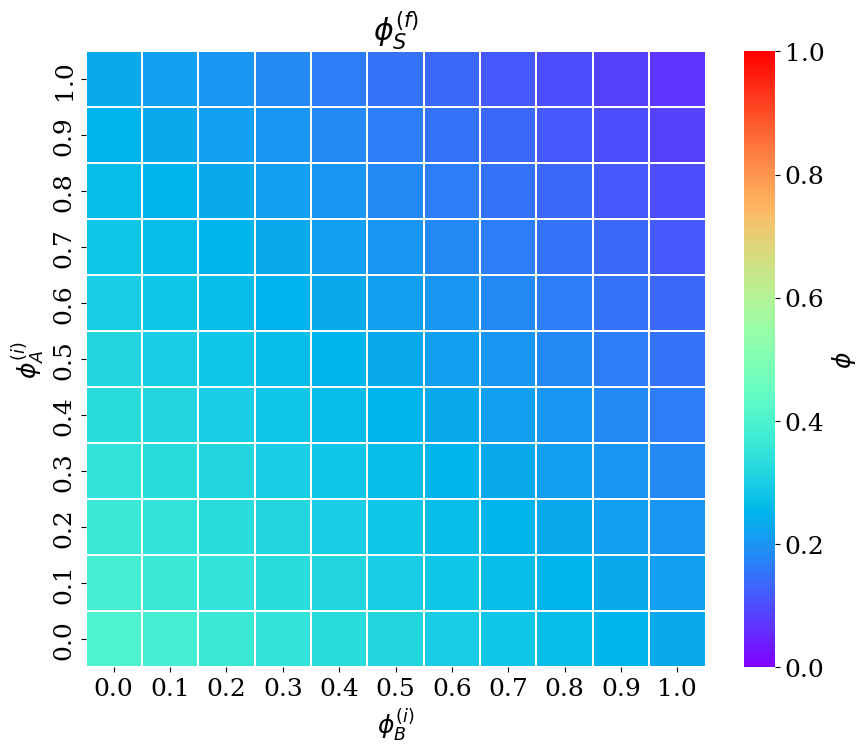

In [7]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# ax = sns.heatmap(phi_a_f, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
#                  cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=1)
ax = sns.heatmap(phi_s, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(phi_b_i, 2), yticklabels=np.round(phi_a_i, 2),\
                 cbar_kws={'label':  r"$\phi$"}, vmin=0, vmax=1)
# spacing = 1
# ax.set_xticks(ax.get_xticks()[::spacing])
# ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
# ax.set_yticks(ax.get_yticks()[::spacing])
# ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("$\phi_A^{(i)}$")
plt.xlabel("$\phi_B^{(i)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$\phi_S^{(f)}$") 

# plt.savefig('OABS_phases.png')

## binding

In [12]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
# e_m = np.array([2, 2]) #binding energy FOR F_BIND_ALT


v_int =  np.array([[-4, 4], [4, -4]])
phi_p = phi_p_f
# phi_s = 
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]


v_s = 1
v_p = 1
v_A = v_p
v_B = v_p
N_P = 5000
N_A = 50
N_B = N_A
b_P = 1
b_A = b_P
b_B = b_P

chi_AB = 20/(N_P*phi_p)

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, phi_s, \
                    poly_marks, v_s, v_p, v_A, v_B, N_P, N_A, N_B,
                    b_P, b_A, b_B, chi_AB)


# klog_min = -2.5
# klog_max = -.1
# klog_num = 30

klog_min = -2.5
klog_max = -1.69 # = np.log10(1/N_A)
klog_num = 10

k_vec = np.logspace(klog_min, klog_max, klog_num) / b_P

### brute force- check all possible values

In [47]:
# %%time

# for a given point on diagram
i = 4
j = 3

phi_p_f

phiaf = phi_a_f[i,j]
phibf = phi_b_f[i,j]
phisf = phi_s[i,j]

# BRUTE FORCE- analytical method messy b/c of summation. but not ruly enoforcing vol frac
# for each possbile pair value of phia_unbound, phib_unbound, 
# calculate phi_bounds 
# and see if consistent (each sums to respective phi_alpah^f s)

# phi_Au_arr = np.arange(0,phiaf, 0.0001)
# phi_Bu_arr = np.arange(0,phibf, 0.0001)
rtol = 0.05
muA_valid, muB_valid, sA_valid, sB_valid, \
fA_valid, fB_valid, phi_Au_valid, phi_Bu_valid, phi_Ab_valid,\
phi_Bb_valid = calc_mu_phi_bind_beaker(psol, phiaf, phibf, rtol)        

In [48]:
muA_valid

array([-3.25422372, -3.25367276, -3.25312296, -3.2282615 , -3.22771095,
       -3.22716156, -3.2029569 , -3.20240676, -3.20185777, -3.17827744,
       -3.1777277 , -3.17717911])

In [ ]:
# ONLY WANT ONE SOLUTION PER point on phase diagram
# need analytical answer
# have 4 unknowns: phiAu, phiAb, phiBu, phiBb
# have 4 equations: phiAb = sum(frac(phius)), phiBb = sum(frac(phius)), phiA = phiAu + phiAb, phiB = phiBu + phiBb
# find a way to deal with complicated binding equation

### Newton raphson

Cant get analytical solution- too complicated. But- use newton raphson (better than brute force!!)


In [22]:
import numpy as np
from numpy.linalg import solve, norm

# for a given point on diagram
i = 4
j = 3



phiaf = phi_a_f[i,j]
phibf = phi_b_f[i,j]
phisf = phi_s[i,j]

v_P = v_p
phiA_tot = phiaf    # scalar
phiB_tot = phibf
phi_p = phi_p_f

C_A = (N_A*v_A)/(N_P*v_P)*phi_p 
C_B = (N_B*v_B)/(N_P*v_P)*phi_p

pA = pa_vec
pB = pb_vec 
epsA = e_m[0]
epsB = e_m[1]

sA = pA * np.exp(epsA) + pB
sB = pB * np.exp(epsB) + pA

def residuals(x,y):
    D = 1.0 + x*sA + y*sB 
    F1 = (phiA_tot - x) - C_A * np.sum( x * sA / D )
    F2 = (phiB_tot - y) - C_B * np.sum( y * sB / D )
    return F1, F2, D

def jacobian(x,y, D):
    # D is vector of denominators for each j
    D2 = D**2
    # partials for F1
    dF1_dx = -1.0 - C_A * np.sum( sA * (1.0 + y * sB) / D2 )
    dF1_dy = - C_A * np.sum( - x * sA * sB / D2 )   # equals -C_A * sum( x*sA*sB / D2 ) times (-1)
    # partials for F2
    dF2_dx = - C_B * np.sum( - y * sB * sA / D2 )
    dF2_dy = -1.0 - C_B * np.sum( sB * (1.0 + x * sA) / D2 )
    return np.array([[dF1_dx, dF1_dy],
                     [dF2_dx, dF2_dy]])

# initial guess
x = max(1e-8, phiA_tot*0.5)
y = max(1e-8, phiB_tot*0.5)

for k in range(60):
    F1,F2,D = residuals(x,y)
    res_norm = np.sqrt(F1**2 + F2**2)
    if res_norm < 1e-12:
        break
    J = jacobian(x,y,D)
    # solve J * delta = -F
    delta = solve(J, -np.array([F1,F2]))
    # damping if step too large could be used; here we try full step:
    x_new = x + delta[0]
    y_new = y + delta[1]
    # enforce non-negativity if physics requires it:
    if x_new < 0: x_new = 1e-12
    if y_new < 0: y_new = 1e-12
    x, y = x_new, y_new

print("solution:", x, y, "residual norm", res_norm, "iters", k)
phi_Au, phi_Bu = x,y

phi_Ab = phiA_tot - phi_Au
phi_Bb = phiB_tot - phi_Bu



# then calc bind array(sA, sB) and mus

solution: 0.03922701102493139 0.029340344266744377 residual norm 6.673614460242277e-17 iters 3


# calc $\phi^{(U)}$ from $\phi^{(B)}$

1) select mu range
2) use tranfer matrix method to calculate binding profile (if no nearest-neighbor interactions, essnetially langmuir isotherm)
3) calculate binding volume fractions
4) use mean-field equations to relate mu, phi_bind to phi_unbound
5) assert sum of bvolue fractions = 1

In [5]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
# e_m = np.array([2, 2]) #binding energy FOR F_BIND_ALT


v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.6
phi_s = 0.1
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]


v_s = 1
v_p = 1
v_A = v_p
v_B = v_p
N_P = 5000
N_A = 50
N_B = N_A
b_P = 1
b_A = b_P
b_B = b_P

chi_AB = 20/(N_P*phi_p)

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, phi_s, \
                    poly_marks, v_s, v_p, v_A, v_B, N_P, N_A, N_B,
                    b_P, b_A, b_B, chi_AB)


# klog_min = -2.5
# klog_max = -.1
# klog_num = 30

klog_min = -2.5
klog_max = -1.69 # = np.log10(1/N_A)
klog_num = 10

k_vec = np.logspace(klog_min, klog_max, klog_num) / b_P

In [19]:
mu1_arr = np.arange(-7,0,0.01)
mu2_arr = np.arange(-7,0,0.01)


In [21]:
def avg_prof_calc(psol, mu):
    #basically langmuir
    mark1, mark2 = psol.poly_marks
    e_A, e_B = psol.e_m
    mu_A, mu_B = mu
    
    p_AmAb = mark1 * np.exp(mu_A+e_A) #A marked A bound
    p_BmAb = mark2 * np.exp(mu_A) #B marked A bound
    p_AmBb = mark1 * np.exp(mu_B) #A marked B bound
    p_BmBb = mark2 * np.exp(mu_B+e_B) #B marked B bound
    
    q = 1 + p_AmAb + p_BmAb + p_AmBb + p_BmBb

    s_Aj = (1*p_AmAb + 1*p_BmAb) / q
    s_Bj = (1*p_AmBb + 1*p_BmBb) / q
    return s_Aj, s_Bj

In [23]:
from scipy.optimize import fsolve

In [25]:
mu1_mat = np.zeros((len(mu1_arr), len(mu2_arr)))
mu2_mat = np.zeros((len(mu1_arr), len(mu2_arr)))
phi_Au_mat = np.zeros((len(mu1_arr), len(mu2_arr)))
phi_Bu_mat = np.zeros((len(mu1_arr), len(mu2_arr)))
phi_Ab_mat = np.zeros((len(mu1_arr), len(mu2_arr)))
phi_Bb_mat = np.zeros((len(mu1_arr), len(mu2_arr)))

for i in range(len(mu1_arr)):
    for j in range(len(mu2_arr)):
        mu1 = mu1_arr[i]
        mu2 = mu2_arr[j]
        s_Aj, s_Bj = avg_prof_calc(psol, [mu1,mu2])
        phi_Ab = ((N_A*v_A)/(N_P*v_p)) * phi_p * np.sum(s_Aj)
        phi_Bb = ((N_B*v_B)/(N_P*v_p)) * phi_p * np.sum(s_Bj)
        # print(phi_Ab)
        # print(phi_Bb)

        phi_Bu_findr = lambda phi_Bu : phi_Bu - np.exp(mu2 - N_B*chi_AB*(phi_Ab + (np.exp(mu1 - N_A*chi_AB*(phi_Bb + phi_Bu))) ))
        # print(fsolve(phi_Bu_findr, [0]))
        phi_Bu = fsolve(phi_Bu_findr, [0])
        # phi_Au = 1 - phi_s - phi_p - phi_Bu - phi_Ab - phi_Bb # WHAT IF DEFINED PHI_AU by fsolve??)
        phi_Au = (np.exp(mu1 - N_A*chi_AB*(phi_Bb + phi_Bu)))
        phi_total = phi_s + phi_p + phi_Au + phi_Bu + phi_Ab + phi_Bb
        # print(phi_Bu)
        if (phi_total > 0.99) and (phi_total < 1.0):
            # print("")
            mu1_mat[i,j] = mu1
            mu2_mat[i,j] = mu2
            phi_Au_mat[i,j] = phi_Au
            phi_Bu_mat[i,j] = phi_Bu
            phi_Ab_mat[i,j] = phi_Ab
            phi_Bb_mat[i,j] = phi_Bb
            # print("mu: ", mu1, mu2)
            # print(phi_total)
            # print("-"*15)

mask_valid = (mu1_mat != 0) & (mu2_mat != 0)
mat_array = [mu1_mat, mu2_mat, phi_Au_mat, phi_Bu_mat, phi_Ab_mat, phi_Bb_mat]#, sA_mat, sB_mat, fA_mat, fB_mat, 
valid_array = []
for mat in mat_array:
    mat_valid = mat[mask_valid]
    valid_array.append(mat_valid)

muA_valid, muB_valid, phi_Au_valid, phi_Bu_valid, phi_Ab_valid, phi_Bb_valid = valid_array

Text(0.5, 1.0, 'langmuir-like')

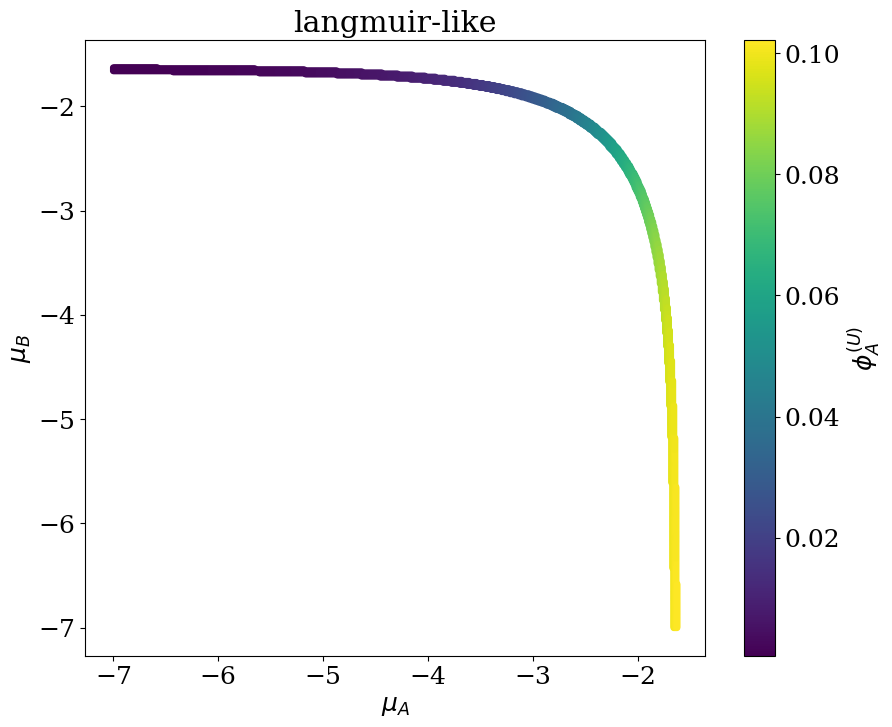

In [26]:
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
plt.scatter(muA_valid, muB_valid, c = phi_Ab_valid, s=15, cmap='viridis')
plt.xlabel(r'$\mu_A$'); plt.ylabel(r'$\mu_B$')
plt.colorbar(label=r'$\phi_A^{(U)}$')
plt.title("langmuir-like")

Text(0.5, 1.0, 'langmuir-like')

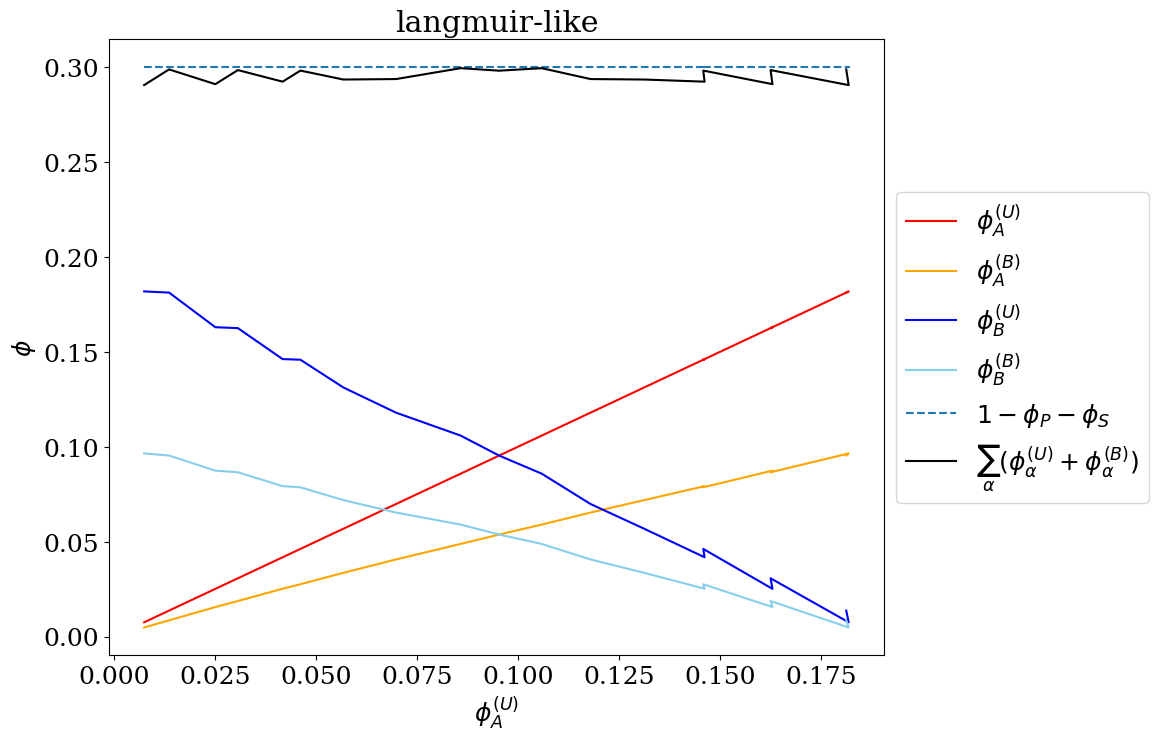

In [17]:
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
plt.plot(phi_Au_valid, phi_Au_valid,  label = "$\phi_A^{(U)}$", color = "red")
plt.plot(phi_Au_valid, phi_Ab_valid, label = "$\phi_A^{(B)}$", color = "orange")


plt.plot(phi_Au_valid, phi_Bu_valid,  label = "$\phi_B^{(U)}$", color = "blue")
plt.plot(phi_Au_valid, phi_Bb_valid, label = "$\phi_B^{(B)}$", color = "skyblue")

plt.plot(phi_Au_valid, 1 - (phi_p + phi_s*np.ones_like(phi_Au_valid)), label = "$1 - \phi_P - \phi_S$", linestyle = "--")
plt.plot(phi_Au_valid, phi_Ab_valid + phi_Au_valid +  phi_Bb_valid + phi_Bu_valid, label = r"$ \sum_\alpha ( \phi_\alpha^{(U)} + \phi_\alpha^{(B)})$", color = "black")

# plt.plot(phi_Au_valid, phi_Ab_valid + phi_Au_valid, label = "$\phi_A^{(U)} + \phi_A^{(B)}$")
# plt.plot(phi_Au_valid, 1 - (phi_p + phi_s*np.ones_like(phi_Au_valid)), label = "$\phi_P + \phi_S$")


plt.ylabel("$\phi$")
plt.xlabel("$\phi_A^{(U)}$")

plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("langmuir-like")

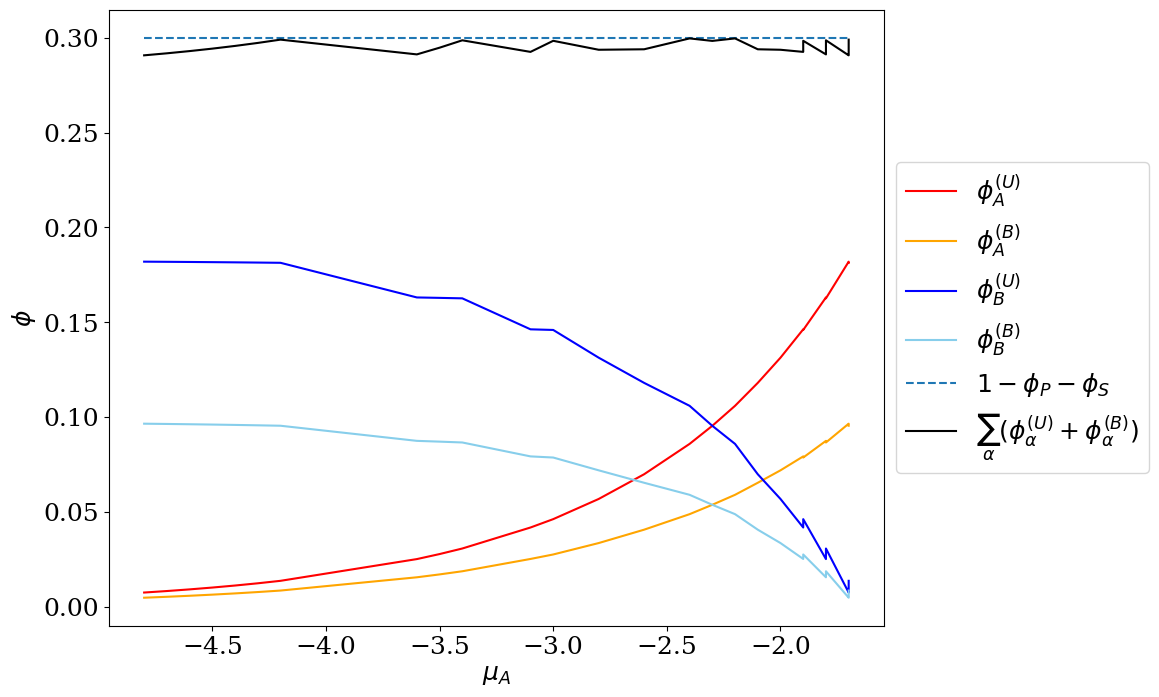

In [19]:
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
plt.plot(muA_valid, phi_Au_valid,  label = "$\phi_A^{(U)}$", color = "red")
plt.plot(muA_valid, phi_Ab_valid, label = "$\phi_A^{(B)}$", color = "orange")

plt.plot(muA_valid, phi_Bu_valid,  label = "$\phi_B^{(U)}$", color = "blue")
plt.plot(muA_valid, phi_Bb_valid, label = "$\phi_B^{(B)}$", color = "skyblue")

plt.plot(muA_valid, 1 - (phi_p + phi_s*np.ones_like(phi_Au_valid)), label = "$1 - \phi_P - \phi_S$", linestyle = "--")
plt.plot(muA_valid, phi_Ab_valid + phi_Au_valid +  phi_Bb_valid + phi_Bu_valid, label = r"$ \sum_\alpha ( \phi_\alpha^{(U)} + \phi_\alpha^{(B)})$", color = "black")

# plt.plot(phi_Au_valid, phi_Ab_valid + phi_Au_valid, label = "$\phi_A^{(U)} + \phi_A^{(B)}$")
# plt.plot(phi_Au_valid, 1 - (phi_p + phi_s*np.ones_like(phi_Au_valid)), label = "$\phi_P + \phi_S$")


plt.ylabel("$\phi$")
plt.xlabel("$\mu_A$")

plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [21]:
muA_valid

array([-4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -3.6, -3.5, -3.4, -3.1,
       -3. , -2.8, -2.6, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.9, -1.8,
       -1.8, -1.8, -1.7, -1.7, -1.7, -1.7, -1.7, -1.7, -1.7])

In [23]:
muB_valid

array([-1.7, -1.7, -1.7, -1.7, -1.7, -1.7, -1.7, -1.8, -1.8, -1.8, -1.9,
       -1.9, -2. , -2.1, -2.2, -2.3, -2.4, -2.6, -2.8, -3.1, -3. , -3.6,
       -3.5, -3.4, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2])

In [25]:
phi_Au_valid

array([0.00750026, 0.00828967, 0.00916223, 0.01012672, 0.01119284,
       0.01237132, 0.01367402, 0.02513452, 0.02778382, 0.03071299,
       0.04178658, 0.04619559, 0.05682674, 0.06986912, 0.08586439,
       0.09539588, 0.10593877, 0.11802763, 0.13131757, 0.14626575,
       0.14593608, 0.1630731 , 0.16284655, 0.1625977 , 0.18193816,
       0.18186057, 0.18177499, 0.18168061, 0.18157657, 0.18146188,
       0.18133551])

In [27]:
phi_Bu_valid

array([0.18193816, 0.18186057, 0.18177499, 0.18168061, 0.18157657,
       0.18146188, 0.18133551, 0.1630731 , 0.16284655, 0.1625977 ,
       0.14626575, 0.14593608, 0.13131757, 0.11802763, 0.10593877,
       0.09539588, 0.08586439, 0.06986912, 0.05682674, 0.04178658,
       0.04619559, 0.02513452, 0.02778382, 0.03071299, 0.00750026,
       0.00828967, 0.00916223, 0.01012672, 0.01119284, 0.01237132,
       0.01367402])

# ARC, only including points where $\sum \phi = 1$

In [63]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
# e_m = np.array([2, 2]) #binding energy FOR F_BIND_ALT


v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.6
phi_s = 0.1
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]


v_s = 1
v_p = 1
v_A = v_p
v_B = v_p
N_P = 5000
N_A = 50
N_B = N_A
b_P = 1
b_A = b_P
b_B = b_P

chi_AB = 20/(N_P*phi_p)

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, phi_s, \
                    poly_marks, v_s, v_p, v_A, v_B, N_P, N_A, N_B,
                    b_P, b_A, b_B, chi_AB)


# klog_min = -2.5
# klog_max = -.1
# klog_num = 30

klog_min = -2.5
klog_max = -1.69 # = np.log10(1/N_A)
klog_num = 10

k_vec = np.logspace(klog_min, klog_max, klog_num) / b_P

In [65]:
%%time
phi_Au_arr = np.arange(0.001, 1 - phi_p - phi_s, 0.001)
phi_Bu_arr = phi_Au_arr

muA_valid, muB_valid, sA_valid, sB_valid, \
fA_valid, fB_valid, phi_Au_valid, phi_Bu_valid, phi_Ab_valid,\
phi_Bb_valid = calc_mu_phi_bind_filter(psol, phi_Au_arr, phi_Bu_arr)

CPU times: total: 10.4 s
Wall time: 10.6 s


In [66]:
# phi_Ab_valid

In [67]:
phi_Au_valid

array([0.001, 0.001, 0.001, ..., 0.195, 0.195, 0.196])

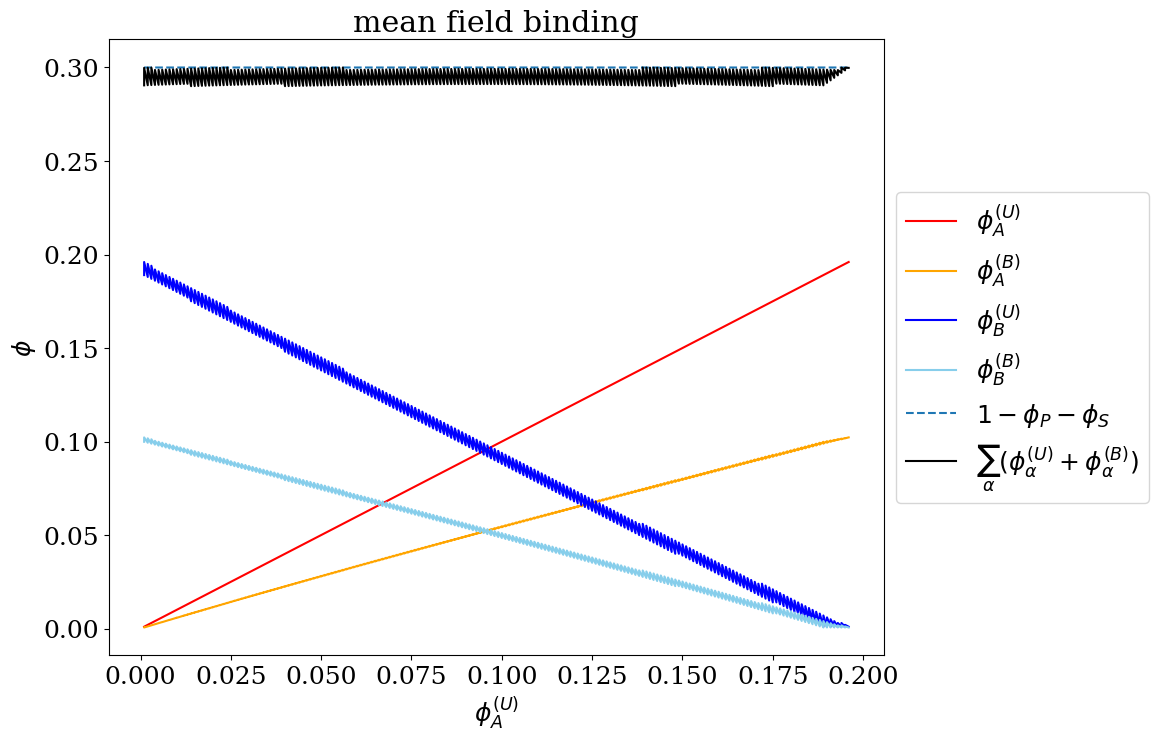

In [75]:
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
plt.plot(phi_Au_valid, phi_Au_valid,  label = "$\phi_A^{(U)}$", color = "red")
plt.plot(phi_Au_valid, phi_Ab_valid, label = "$\phi_A^{(B)}$", color = "orange")


plt.plot(phi_Au_valid, phi_Bu_valid,  label = "$\phi_B^{(U)}$", color = "blue")
plt.plot(phi_Au_valid, phi_Bb_valid, label = "$\phi_B^{(B)}$", color = "skyblue")

plt.plot(phi_Au_valid, 1 - (phi_p + phi_s*np.ones_like(phi_Au_valid)), label = "$1 - \phi_P - \phi_S$", linestyle = "--")
plt.plot(phi_Au_valid, phi_Ab_valid + phi_Au_valid +  phi_Bb_valid + phi_Bu_valid, label = r"$ \sum_\alpha ( \phi_\alpha^{(U)} + \phi_\alpha^{(B)})$", color = "black")

# plt.plot(phi_Au_valid, phi_Ab_valid + phi_Au_valid, label = "$\phi_A^{(U)} + \phi_A^{(B)}$")
# plt.plot(phi_Au_valid, 1 - (phi_p + phi_s*np.ones_like(phi_Au_valid)), label = "$\phi_P + \phi_S$")


plt.ylabel("$\phi$")
plt.xlabel("$\phi_A^{(U)}$")
plt.title("mean field binding")
plt.legend()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

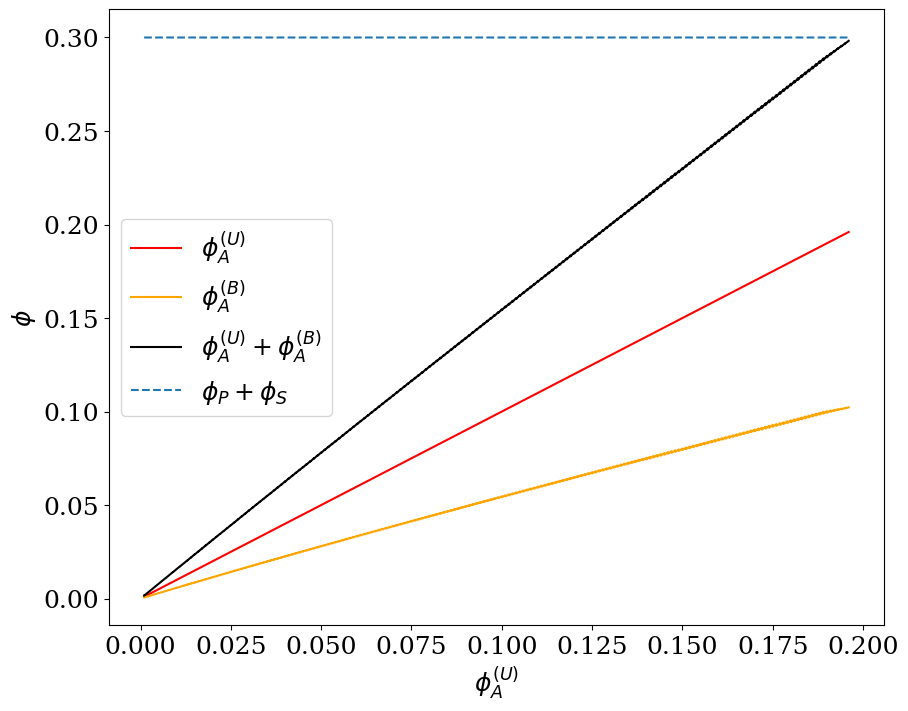

In [35]:
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
plt.plot(phi_Au_valid, phi_Au_valid,  label = "$\phi_A^{(U)}$", color = "red")


plt.plot(phi_Au_valid, phi_Ab_valid, label = "$\phi_A^{(B)}$", color = "orange")
plt.plot(phi_Au_valid, phi_Ab_valid + phi_Au_valid, label = "$\phi_A^{(U)} + \phi_A^{(B)}$", color = "black")
plt.plot(phi_Au_valid, 1 - (phi_p + phi_s*np.ones_like(phi_Au_valid)), label = "$\phi_P + \phi_S$", linestyle = "--")


plt.ylabel("$\phi$")
plt.xlabel("$\phi_A^{(U)}$")

plt.legend()

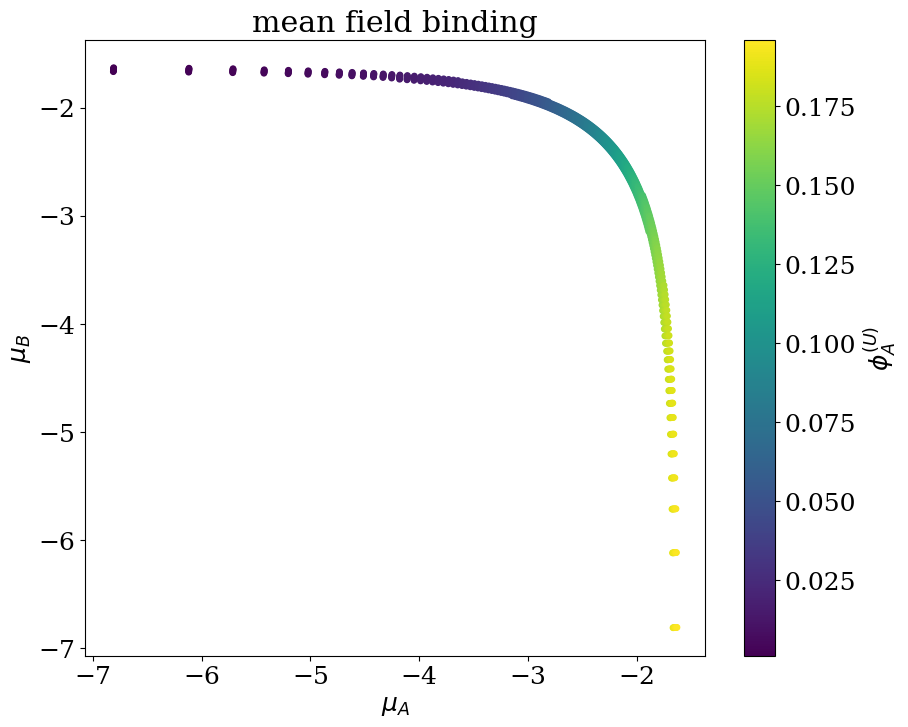

In [79]:
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
plt.scatter(muA_valid, muB_valid, c=phi_Au_valid, s=15, cmap='viridis')
plt.xlabel(r'$\mu_A$'); plt.ylabel(r'$\mu_B$')
plt.title("mean field binding")

plt.colorbar(label=r'$\phi_A^{(U)}$')

## spinodal

In [39]:
%%time
# chi_AP = 0
# chi_BP = 0
# # chi_AB = 69.5 / (phi_p*N_P) 
# chi_PS = 0
# chi_AS = 0
# chi_BS = 0

# chis = [chi_AP, chi_BP, chi_AB, chi_PS, chi_AS, chi_BS]


min_eigval_arr = np.zeros((len(phi_Au_valid), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros(len(phi_Au_valid))
min_eigval_arr_allk_ps = np.zeros(len(phi_Au_valid))

# min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 5))
# min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 5))
min_eigvec_arr = np.zeros((len(phi_Au_valid), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_valid), 3))
k_star_arr_DENS= np.zeros(len(phi_Au_valid))

cond_num_arr = np.zeros((len(phi_Au_valid), len(k_vec)))
max_cond_arr = np.zeros(len(phi_Au_valid))

for i in range(len(phi_Au_valid)):
#         if mu1 == mu2:
#             continue
        # mu = [mu1, mu2]
        # print("mu: ", mu)
        s_bnd_A = sA_valid[i]
        s_bnd_B = sB_valid[i]

        phi_Au = phi_Au_valid[i]
        phi_Bu = phi_Bu_valid[i]

        phius = [phi_Au, phi_Bu]
        # if i == 0 and j == len(phi_Au_arr)-1:
        #     print("SA: ", s_bnd_A)
        #     print("SB: ", s_bnd_B)
        for ik, k in enumerate(k_vec):

            # print(k)

            # s_bnd_A = s_bind_A_ALL[i, j]
            # s_bnd_B = s_bind_B_ALL[i, j]

            # M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            # S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            # cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, phius, k)

            
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            # print(val)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][ik] = min_val
            min_eigvec_arr[i][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][:][np.nonzero(min_eigval_arr[i][:])] 
        min_vecs = min_eigvec_arr[i][:][np.nonzero(min_eigval_arr[i][:])]

        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i] = minval_allk 
        min_eigvec_arr_allk_DENS[i] = min_vecs[np.where(min_vals==minval_allk)]

        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i] = k_star

        # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

CPU times: total: 20 s
Wall time: 21.5 s


In [41]:
spinodal = np.copy(k_star_arr_DENS)
spinodal[np.where(spinodal == k_vec[0])] = 0 # macro
spinodal[np.where(spinodal > k_vec[0])] = 1 # micro

In [40]:
# spinodal

Text(0.5, 1.0, '$e_m = $1.52, $phi_P N_P \\chi_{AB} = $20.0')

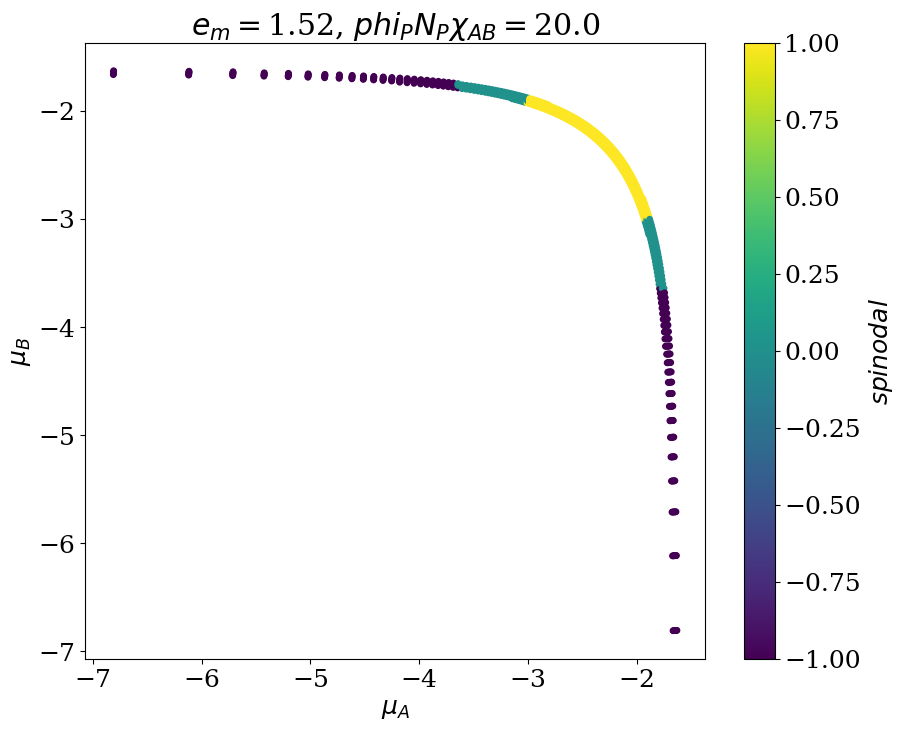

In [47]:
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
plt.scatter(muA_valid, muB_valid, c=spinodal, s=15, cmap='viridis')
plt.xlabel(r'$\mu_A$'); plt.ylabel(r'$\mu_B$')
plt.colorbar(label=r'$spinodal$')
plt.title("$e_m = $" + str(e_m[0]) + ", $phi_P N_P \chi_{AB} = $" + str(phi_p * N_P * psol.chi_AB))

## phases

In [28]:
%%time

# mu1_i = 5
# mu2_i = 6
# mu1_array[mu1_i]
# chi = 0
# chis = [chi_AB, chi_AS]
# mu1_i_min = 5
# mu1_i_max = 15
# mu2_i_min = 5
# mu2_i_max = 15
# phases = np.zeros((len(mu1_array[mu1_i_min:mu1_i_max]), len(mu2_array[mu2_i_min:mu2_i_max]))) - 1 
# minF_arr = np.zeros((len(mu1_array[mu1_i_min:mu1_i_max]), len(mu2_array[mu2_i_min:mu2_i_max]))) 

# mu1_i = 0
# mu2_j = 6

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal
# k_star_arr_DENS[np.where(k_star_arr_DENS == k_vec[0]) ] = -1 # unphysical value, to indicate macrophase separation


phases = np.zeros(len(phi_Au_valid)) - 1 
minF_arr = np.zeros_like(phases) 
for i in range(len(phi_Au_valid)):
    # if i != mu1_i:
    #     continue
    # if j != mu2_j:
    #     continue

    # print("mu: ", mu1, mu2)
    q_star = k_star_arr_DENS[i]
    vec_star = min_eigvec_arr_allk_DENS[i]

    
    if q_star == -1:
        print("out of spinodal; no q_star")
        phases[i] = 0 # disordered phase- outside of spinodal
    elif q_star == k_vec[0]:
    # elif q_star != k_vec[-1]:
        print("macrophase sep")
        phases[i] = 1 # macrophase sep

    else: #microphse sep
    
        s_bnd_A = sA_valid[i,:]#s_bind_A_ALL[i,j,:]
        s_bnd_B = sB_valid[i,:]#s_bind_B_ALL[i,j,:]

        phius = [phi_Au_valid[i], phi_Bu_valid[i]]
        lam_q = q_star*np.array([1, 0, 0])
        lam_q = np.linalg.norm(lam_q)

        cyl_q1 = q_star*np.array([1, 0, 0])
        # cyl_q1 = np.linalg.norm(cyl_q1)
        cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
        # cyl_q2 = np.linalg.norm(cyl_q2)
        cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
        # cyl_q3 = np.linalg.norm(cyl_q3)
        cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
        
        bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
        bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
        bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
        bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
        bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
        bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
        
        
        lam_g3 = 0
        G3 = gamma3(psol, s_bnd_A, s_bnd_B, phius, cyl_qs) # all g3s are eqivlaent
        cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
        bcc_g3 = (4/(3*np.sqrt(6))) * G3
        
        G4_00 = gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([lam_q, -lam_q, lam_q, -lam_q]))
        lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
        
        cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
          72*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
        
        bcc_g4 = (1/24)* (G4_00 \
                 + 8*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
                 + 2*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
                 + 4*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )

        lam_g2 = (1/2) * 2 * (1) * gamma2_chis(psol, s_bnd_A, s_bnd_B, phius, q_star)
        cyl_g2 = lam_g2
        bcc_g2 = lam_g2

        # # # PHYSICALLY BOUNDED AMPLITUDE
        # # del_phi = phi - phi_0. phi goes from 0 to phi_p. therefore del_phi(max) = phi_p-phi_0 ; del_phi(min) = - phi_0
        # # need to use a sigmoid (goes 0 to 1) then del_phi = phi_p * sigmoid(amps) - phi_0 ; phi_0 = [f_O, f_A, f_B]
        # # raise Exception("NNED to implement phi right----- look below :D")
        # phi_0 = phi_p * np.array([fo_mat[0][0], fa_mat[0][0], fb_mat[0][0]])
        # initial = [0, 0, 0] # poly, A, B
        # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
        #                                                 phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
        # lamF_q = res.fun
        
        # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
        #                                    #  + np.einsum("ijk,i,j,k ->", cyl_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
        #                                    # +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
        #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
        # cylF_q = 1000000000#res.fun

        # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
        #                                    #  + np.einsum("ijk,i,j,k ->", bcc_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
        #                                    # +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
        #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
        # bccF_q = 1000000000#res.fun          




        print("made it to crit fluc")            
        # CRITICAL FLUCTIATION
        # define a lambda scalar value for a given critica lfluctutaion, then use roots equation to find cirtical points, and eval F at each
        lam_lambda_2 = np.einsum("ij,i,j ->", lam_g2, vec_star, vec_star)
        lam_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -lam_g4, vec_star, vec_star, vec_star, vec_star)

        pos_l_amps = np.real(np.roots([4*lam_lambda_4,0,2*lam_lambda_2,0]))        
        lamF = min(np.real( lam_lambda_2 * pos_l_amps**2 + lam_lambda_4 * pos_l_amps**4))

        
        cyl_lambda_2 = np.einsum("ij,i,j ->", cyl_g2, vec_star, vec_star)
        cyl_lambda_3 = np.einsum("ijk,i,j,k->", cyl_g3, vec_star, vec_star, vec_star)
        cyl_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -cyl_g4, vec_star, vec_star, vec_star, vec_star)

        pos_c_amps = np.real(np.roots([4*cyl_lambda_4,3*cyl_lambda_3,2*cyl_lambda_2,0]))        
        cylF = min(np.real( cyl_lambda_2 * pos_c_amps**2 + cyl_lambda_3*pos_c_amps**3 + cyl_lambda_4 * pos_c_amps**4))

        
        bcc_lambda_2 = np.einsum("ij,i,j ->", bcc_g2, vec_star, vec_star)
        bcc_lambda_3 = np.einsum("ijk,i,j,k->", bcc_g3, vec_star, vec_star, vec_star)
        bcc_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -bcc_g4, vec_star, vec_star, vec_star, vec_star)

        pos_b_amps = np.real(np.roots([4*bcc_lambda_4,3*bcc_lambda_3,2*bcc_lambda_2,0]))        
        bccF = min(np.real( bcc_lambda_2 * pos_b_amps**2 + bcc_lambda_3*pos_b_amps**3 + bcc_lambda_4 * pos_b_amps**4))        


        

        # # # BASINHOPPING UNRESTRICTED works at low chi
    
        # initial = [0, 0, 0] # poly, A, B
        # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, amps, amps, amps, amps)), initial)
        # lamF_q = res.fun
        # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
        #                                     + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4, amps, amps, amps, amps)), initial)
        # cylF_q = res.fun

        # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
        #                                     + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
        #                                    +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4, amps, amps, amps, amps)), initial)
        # bccF_q = res.fun            


        
        minF = np.min([lamF, cylF, bccF, 0])
        minF_arr[i] = minF
        # print("--------------------------------------------------------------------")
        # print("energies:")
        print([lamF, cylF, bccF, 0])
        # print("--------------------------------------------------------------------")

        # # print([lamF])
        # # print([lamF, cylF])#, bccF])
        if minF == 0:
            # raise Exception("phase sep not stable in spinodal??")
            phases[i] = -2
        elif minF == lamF:
            phases[i] = 2
        elif minF == cylF:
            phases[i] = 3
        elif minF == bccF:
            phases[i] = 4

    np.save("expl_bind_minF_valid_em="+str(e_m[0]), minF_arr)
    np.save("expl_bind_phases_valid_em="+str(e_m[0]), phases)
        

out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
macrophase sep
macrophase sep
made it to crit fluc
[-3.058824910979719e-24, -1.9804879198482412e-24, -1.3372684046634612e-24, 0]
made it to crit fluc
[-2.124458130942544e-23, -1.341238773982837e-23, -9.028868113698366e-24, 0]
made it to crit fluc
[-1.4938027199241722e-22, -9.266418207727929e-23, -6.220737904177103e-23, 0]
made it to crit fluc
[-1.6713816056279288e-21, -1.0237618202741089e-21, -6.85913497397741e-22, 0]
made it to crit fluc
[-1.6159702141499316e-19, -9.796046322898197e-20, -6.552657880176258e-20, 0]
made it to crit fluc
[-1.6159642807268157e-19, -9.796134310965777e-20, -6.552730307869072e-20, 0]
made it to crit fluc
[-1.6713796820127724e-21, -1.0237621405463907e-21, -6.859138895404142e-22, 0]
made it to crit fluc
[-1.4938018156260166e-22, -9.266417627547876e-23, -6.220738144766355e-23, 0]
made it to crit fluc
[-2.1244573945449044e-23, -1.3412386847287885e-23, -9.028867999757321e-24, 0]
made 

In [29]:
vec_star

array([0., 0., 0.])

In [31]:
psol.chi_AB

0.006666666666666667

Text(0.5, 1.0, '$e_m = $1.52, $phi_P N_P \\chi_{AB} = $20.0')

<Figure size 640x480 with 0 Axes>

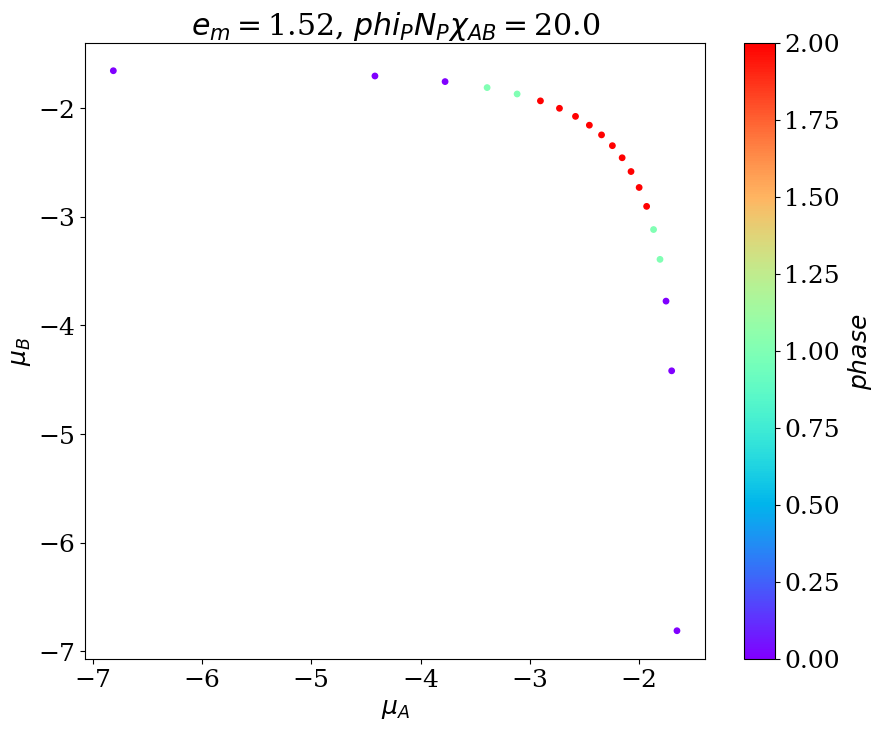

In [32]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.scatter(muA_valid, muB_valid, c=phases, s=15, cmap='rainbow')
plt.xlabel(r'$\mu_A$'); plt.ylabel(r'$\mu_B$')
plt.colorbar(label=r'$phase$')
plt.title("$e_m = $" + str(e_m[0]) + ", $phi_P N_P \chi_{AB} = $" + str(phi_p * N_P * psol.chi_AB))

# GRID, including invalid points

In [13]:
# Eigvect restircted minimization

n_bind = 2 #types of proteins/marks
# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
# e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT
e_m = np.array([2, 2]) #binding energy FOR F_BIND_ALT


v_int =  np.array([[-4, 4], [4, -4]])
phi_p = 0.6
phi_s = 0.1
M = 50
nm = M
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec
poly_marks = [pa_vec, pb_vec]


v_s = 1
v_p = 1
v_A = v_p
v_B = v_p
N_P = 5000
N_A = 50
N_B = N_A
b_P = 1
b_A = b_P
b_B = b_P

chi_AB = 100/(N_P*phi_p)

psol = Polymer_soln(n_bind, v_int, e_m, phi_p, phi_s, \
                    poly_marks, v_s, v_p, v_A, v_B, N_P, N_A, N_B,
                    b_P, b_A, b_B, chi_AB)


# klog_min = -2.5
# klog_max = -.1
# klog_num = 30

klog_min = -2.5
klog_max = -1.69 # = np.log10(1/N_A)
klog_num = 10

k_vec = np.logspace(klog_min, klog_max, klog_num) / b_P

In [15]:
k_vec

array([0.00316228, 0.00389045, 0.0047863 , 0.00588844, 0.00724436,
       0.00891251, 0.01096478, 0.01348963, 0.01659587, 0.02041738])

In [17]:
1/(N_P/M) # What the maximum wavevector should be (minimum lengthscale where microphassse separation can occur

1/N_A # What the maximum wavevector should be (minimum lengthscale where microphassse separation can occur

0.02

In [19]:
np.log10(1/N_A) 

-1.6989700043360187

In [21]:
phi_Au_arr = np.arange(0.001, 0.07, 0.01)
# phi_Au_arr = np.arange(0.001, 0.1, 0.01)

phi_Bu_arr = phi_Au_arr

muA_mat, muB_mat, sA_mat, sB_mat, \
fA_mat, fB_mat, phi_Au_mat, phi_Bu_mat, phi_Ab_mat,\
phi_Bb_mat = calc_mu_phi_bind(psol, phi_Au_arr, phi_Bu_arr)

phi_tot =  0.704495779594649
phi_tot =  0.726284943040599
phi_tot =  0.747018333992745
phi_tot =  0.7668441188407721
phi_tot =  0.7858826343387925
phi_tot =  0.8042328201762989
phi_tot =  0.8219769119208759
phi_tot =  0.726284943040599
phi_tot =  0.7473450533117791
phi_tot =  0.7674293621627837
phi_tot =  0.786673269382395
phi_tot =  0.805186985329993
phi_tot =  0.8230613039527835
phi_tot =  0.8403718265920523
phi_tot =  0.747018333992745
phi_tot =  0.7674293621627837
phi_tot =  0.786934869467315
phi_tot =  0.8056591365388865
phi_tot =  0.8237035372914265
phi_tot =  0.8411517453793342
phi_tot =  0.8580735540421734
phi_tot =  0.7668441188407721
phi_tot =  0.786673269382395
phi_tot =  0.8056591365388865
phi_tot =  0.8239162388773672
phi_tot =  0.8415381781040194
phi_tot =  0.8586023547870095
phi_tot =  0.8751734374751131
phi_tot =  0.7858826343387925
phi_tot =  0.805186985329993
phi_tot =  0.8237035372914265
phi_tot =  0.8415381781040194
phi_tot =  0.8587776258057381
phi_tot =  0.8754937

In [7]:

chi_AP = 0
chi_BP = 0
# chi_AB = 69.5 / (phi_p*N_P) 
chi_PS = 0
chi_AS = 0
chi_BS = 0

# chis = [chi_AP, chi_BP, chi_AB, chi_PS, chi_AS, chi_BS]


min_eigval_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec)))

min_eigval_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))
min_eigval_arr_allk_ps = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))

# min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 5))
# min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 5))
min_eigvec_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), 3))
k_star_arr_DENS= np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]))) 

cond_num_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:]), len(k_vec)))
max_cond_arr = np.zeros((len(phi_Au_arr[:]), len(phi_Bu_arr[:])))

for i in range(len(phi_Au_arr)):
    for j in range(len(phi_Bu_arr)):
#         if mu1 == mu2:
#             continue
        # mu = [mu1, mu2]
        # print("mu: ", mu)
        s_bnd_A = sA_mat[i,j]
        s_bnd_B = sB_mat[i,j]

        phi_Au = phi_Au_mat[i,j]
        phi_Bu = phi_Bu_mat[i,j]

        phius = [phi_Au, phi_Bu]
        # if i == 0 and j == len(phi_Au_arr)-1:
        #     print("SA: ", s_bnd_A)
        #     print("SB: ", s_bnd_B)
        for ik, k in enumerate(k_vec):

            # print(k)

            # s_bnd_A = s_bind_A_ALL[i, j]
            # s_bnd_B = s_bind_B_ALL[i, j]

            # M2s = calc_mon_mat_2(s_bnd_A, s_bnd_B, competitive)
            # S2_mat = (phi_p / N) * calc_sf2(psol, M2s, [k], competitive)
            # cond_num_arr[i][j][ik] = np.linalg.cond(S2_mat)

            G2 = gamma2_chis(psol, s_bnd_A, s_bnd_B, phius, k)

            
            # s_bnd_A = s_bind_A_ar[i, j]
            # s_bnd_B = s_bind_B_ar[i, j]

            # G2 = gamma2(chrom, s_bnd_A, s_bnd_B, k, chi, competitive)

            
            val, vec = np.linalg.eigh(G2)
            # print(val)
            vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
            min_val = np.min(val)            
            min_eigval_arr[i][j][ik] = min_val
            min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]


        # all-k analysis
        # min eigvals, eigvecs at given mu1,mu2 for each k        
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] 
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]

        # minimum eigenvalue at given mu1,mu2 across all ks
        minval_allk = np.min(min_vals) 
        
        # store this eigenvalue and corresponding eigenvector
        min_eigval_arr_allk_DENS[i][j] = minval_allk 
        min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]

        k_star = k_vec[np.where(min_vals==minval_allk)]
        k_star_arr_DENS[i][j] = k_star

        # max_cond_num = np.max(cond_num_arr[i][j][:])#[np.nonzero(min_eigval_arr[i][j][:])] 
        # max_cond_arr[i][j] = max_cond_num
# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

In [8]:
spinodal = np.copy(k_star_arr_DENS)
spinodal[np.where(spinodal == k_vec[0])] = 0 # macro
spinodal[np.where(spinodal > k_vec[0])] = 1 # micro

Text(0.5, 1.0, '$with \\ unbound  \\ guests, \\ \\phi_{Ab}, \\phi_{Au}, etc \\ explicit $\n$ N_P $= 5000,  $N_A = N_B$ = 1, \n $N_p \\phi_p \\chi_{AB} = $100.0, $\\chi_{PS} = \\chi_{AS} = \\chi_{BS} =$0, $\\epsilon_b = $2')

<Figure size 640x480 with 0 Axes>

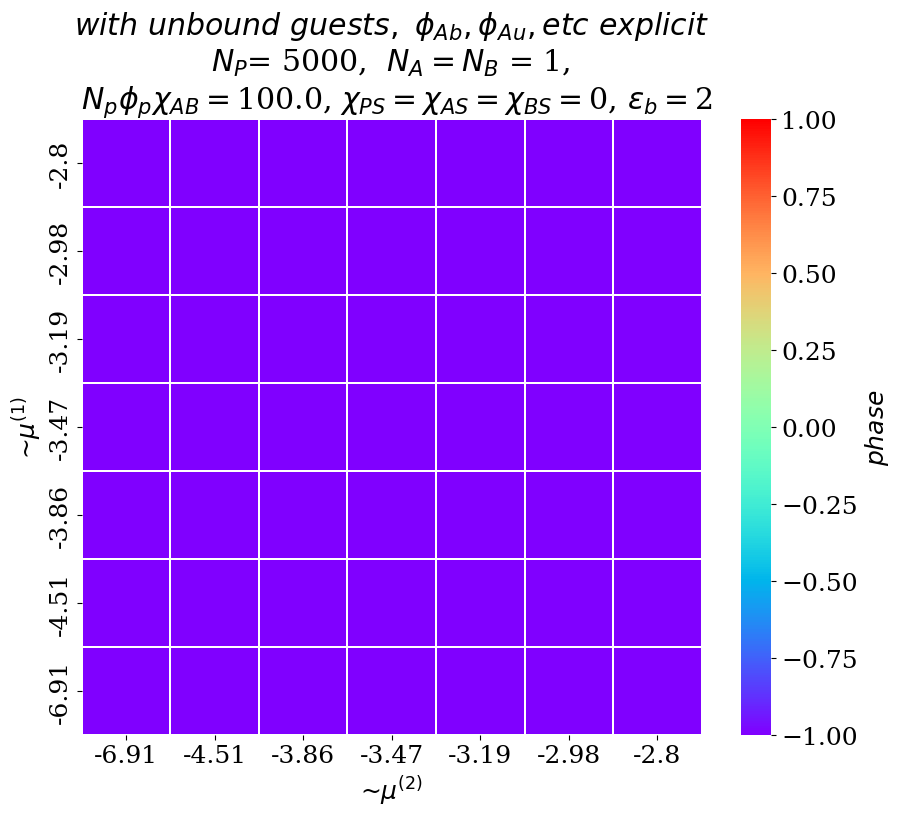

In [9]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ax = sns.heatmap(spinodal, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
                 cbar_kws={'label':  r"$phase$"}, vmin=-1, vmax=1)

spacing = 1
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("~$\mu^{(1)}$")
plt.xlabel("~$\mu^{(2)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$with \ unbound  \ guests, \ \phi_{Ab}, \phi_{Au}, etc \ explicit $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A  \
          +  "\n" +" $N_p \phi_p \chi_{AB} = $" + \
          str(np.round(chi_AB*N_P*phi_p,1)) +", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
         + ", $\epsilon_b = $" + str(e_m[0])) 

# plt.savefig('OABS_phases.png')

In [10]:
k_star_arr_DENS

array([[-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.]])

In [11]:
k_vec[0]

0.0031622776601683794

In [12]:
np.shape(sA_mat)

(7, 7, 50)

In [13]:
# np.save("testerrr", sA_mat+1)

In [14]:
# %%time

# mu1_i = 5
# mu2_i = 6
# mu1_array[mu1_i]
# chi = 0
# chis = [chi_AB, chi_AS]
# mu1_i_min = 5
# mu1_i_max = 15
# mu2_i_min = 5
# mu2_i_max = 15
# phases = np.zeros((len(mu1_array[mu1_i_min:mu1_i_max]), len(mu2_array[mu2_i_min:mu2_i_max]))) - 1 
# minF_arr = np.zeros((len(mu1_array[mu1_i_min:mu1_i_max]), len(mu2_array[mu2_i_min:mu2_i_max]))) 

# mu1_i = 0
# mu2_j = 6

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal
# k_star_arr_DENS[np.where(k_star_arr_DENS == k_vec[0]) ] = -1 # unphysical value, to indicate macrophase separation


phases = np.zeros((len(phi_Au_arr), len(phi_Bu_arr))) - 1 
minF_arr = np.zeros((len(phi_Au_arr), len(phi_Bu_arr))) 
for i, phi_Au in enumerate(phi_Au_arr):
    for j, phi_Bu in enumerate(phi_Bu_arr):
        # if i != mu1_i:
        #     continue
        # if j != mu2_j:
        #     continue

        # print("mu: ", mu1, mu2)
        q_star = k_star_arr_DENS[i,j]
        vec_star = min_eigvec_arr_allk_DENS[i,j]

        
        if q_star == -1:
            print("out of spinodal; no q_star")
            phases[i,j] = 0 # disordered phase- outside of spinodal
        elif q_star == k_vec[0]:
        # elif q_star != k_vec[-1]:
            print("macrophase sep")
            phases[i,j] = 1 # macrophase sep

        else: #microphse sep
        
            s_bnd_A = sA_mat[i,j,:]#s_bind_A_ALL[i,j,:]
            s_bnd_B = sB_mat[i,j,:]#s_bind_B_ALL[i,j,:]

            pihus = [phi_Au, phi_Bu]
            lam_q = q_star*np.array([1, 0, 0])
            lam_q = np.linalg.norm(lam_q)
    
            cyl_q1 = q_star*np.array([1, 0, 0])
            # cyl_q1 = np.linalg.norm(cyl_q1)
            cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
            # cyl_q2 = np.linalg.norm(cyl_q2)
            cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
            # cyl_q3 = np.linalg.norm(cyl_q3)
            cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
            
            bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
            bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
            bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
            bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
            bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
            bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
            
            
            lam_g3 = 0
            G3 = gamma3(psol, s_bnd_A, s_bnd_B, phius, cyl_qs) # all g3s are eqivlaent
            cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
            bcc_g3 = (4/(3*np.sqrt(6))) * G3
            
            G4_00 = gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([lam_q, -lam_q, lam_q, -lam_q]))
            lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
            
            cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
              72*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
            
            bcc_g4 = (1/24)* (G4_00 \
                     + 8*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
                     + 2*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
                     + 4*gamma4(psol, s_bnd_A, s_bnd_B, phius, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
    
            lam_g2 = (1/2) * 2 * (1) * gamma2_chis(psol, s_bnd_A, s_bnd_B, phius, q_star)
            cyl_g2 = lam_g2
            bcc_g2 = lam_g2

            # # # PHYSICALLY BOUNDED AMPLITUDE
            # # del_phi = phi - phi_0. phi goes from 0 to phi_p. therefore del_phi(max) = phi_p-phi_0 ; del_phi(min) = - phi_0
            # # need to use a sigmoid (goes 0 to 1) then del_phi = phi_p * sigmoid(amps) - phi_0 ; phi_0 = [f_O, f_A, f_B]
            # # raise Exception("NNED to implement phi right----- look below :D")
            # phi_0 = phi_p * np.array([fo_mat[0][0], fa_mat[0][0], fb_mat[0][0]])
            # initial = [0, 0, 0] # poly, A, B
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                                 phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # lamF_q = res.fun
            
            # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    #  + np.einsum("ijk,i,j,k ->", cyl_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    # +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # cylF_q = 1000000000#res.fun

            # res = 0#sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    #  + np.einsum("ijk,i,j,k ->", bcc_g3, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0) \
            #                                    # +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4,  phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0, \
            #                                    #              phi_p*sigmoid(amps)-phi_0, phi_p*sigmoid(amps)-phi_0)), initial)
            # bccF_q = 1000000000#res.fun          




            print("made it to crit fluc")            
            # CRITICAL FLUCTIATION
            # define a lambda scalar value for a given critica lfluctutaion, then use roots equation to find cirtical points, and eval F at each
            lam_lambda_2 = np.einsum("ij,i,j ->", lam_g2, vec_star, vec_star)
            lam_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -lam_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_l_amps = np.real(np.roots([4*lam_lambda_4,0,2*lam_lambda_2,0]))        
            lamF = min(np.real( lam_lambda_2 * pos_l_amps**2 + lam_lambda_4 * pos_l_amps**4))
    
            
            cyl_lambda_2 = np.einsum("ij,i,j ->", cyl_g2, vec_star, vec_star)
            cyl_lambda_3 = np.einsum("ijk,i,j,k->", cyl_g3, vec_star, vec_star, vec_star)
            cyl_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -cyl_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_c_amps = np.real(np.roots([4*cyl_lambda_4,3*cyl_lambda_3,2*cyl_lambda_2,0]))        
            cylF = min(np.real( cyl_lambda_2 * pos_c_amps**2 + cyl_lambda_3*pos_c_amps**3 + cyl_lambda_4 * pos_c_amps**4))
    
            
            bcc_lambda_2 = np.einsum("ij,i,j ->", bcc_g2, vec_star, vec_star)
            bcc_lambda_3 = np.einsum("ijk,i,j,k->", bcc_g3, vec_star, vec_star, vec_star)
            bcc_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -bcc_g4, vec_star, vec_star, vec_star, vec_star)
    
            pos_b_amps = np.real(np.roots([4*bcc_lambda_4,3*bcc_lambda_3,2*bcc_lambda_2,0]))        
            bccF = min(np.real( bcc_lambda_2 * pos_b_amps**2 + bcc_lambda_3*pos_b_amps**3 + bcc_lambda_4 * pos_b_amps**4))        


            

            # # # BASINHOPPING UNRESTRICTED works at low chi
        
            # initial = [0, 0, 0] # poly, A, B
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -lam_g4, amps, amps, amps, amps)), initial)
            # lamF_q = res.fun
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
            #                                     + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -cyl_g4, amps, amps, amps, amps)), initial)
            # cylF_q = res.fun
    
            # res = sp.optimize.basinhopping(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
            #                                     + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
            #                                    +  np.einsum("ijkl,i,j,k,l ->", -bcc_g4, amps, amps, amps, amps)), initial)
            # bccF_q = res.fun            


            
            minF = np.min([lamF, cylF, bccF, 0])
            minF_arr[i,j] = minF
            # print("--------------------------------------------------------------------")
            # print("energies:")
            print([lamF, cylF, bccF, 0])
            # print("--------------------------------------------------------------------")

            # # print([lamF])
            # # print([lamF, cylF])#, bccF])
            if minF == 0:
                # raise Exception("phase sep not stable in spinodal??")
                phases[i,j] = -2
            elif minF == lamF:
                phases[i,j] = 2
            elif minF == cylF:
                phases[i,j] = 3
            elif minF == bccF:
                phases[i,j] = 4

        np.save("expl_bind_minF_test_all_phases_SMALLBINDER_em="+str(e_m[0]), minF_arr)
        np.save("expl_bind_phases_test_all_phases_SMALLBINDER_em="+str(e_m[0]), phases)
            

out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
out of spinodal; no q_star
o

Text(0.5, 1.0, '$with \\ unbound  \\ guests, \\ \\phi_{Ab}, \\phi_{Au}, etc \\ explicit $\n$ N_P $= 5000,  $N_A = N_B$ = 50, \n $N_p \\phi_p \\chi_{AB} = $100.0, $\\chi_{PS} = \\chi_{AS} = \\chi_{BS} =$0, $\\epsilon_b = $2')

<Figure size 640x480 with 0 Axes>

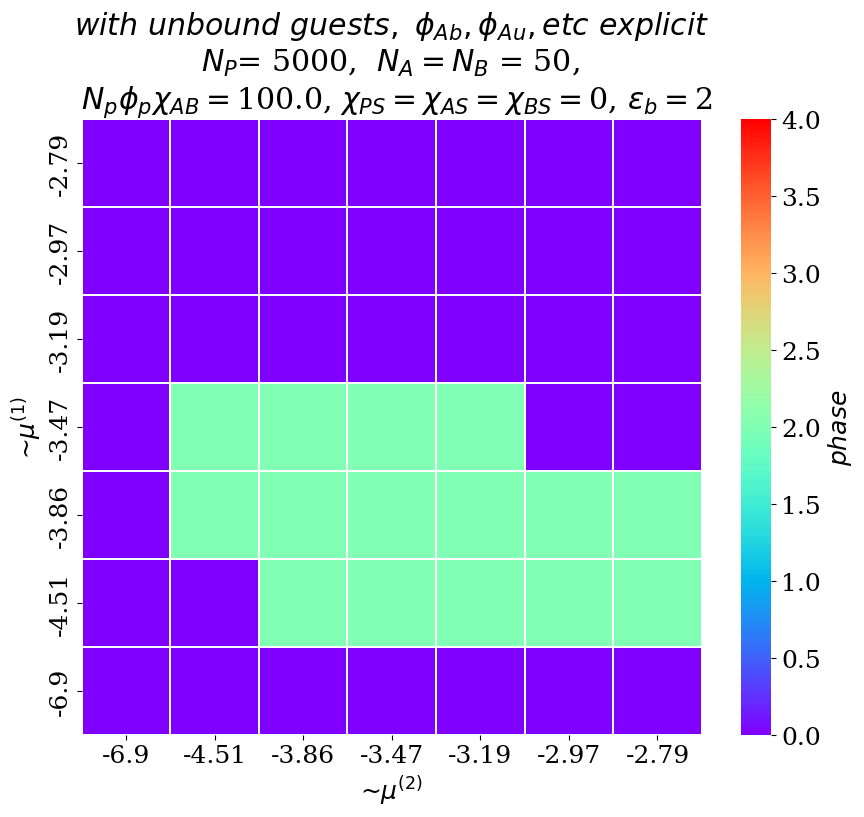

In [58]:
# err = np.sum(phases < 0)
# if err > 0 :
#     raise Exception("IVALID!!")
    
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

ax = sns.heatmap(phases, linewidth=0.25, cmap = "rainbow", xticklabels=np.round(muB_mat[0,:],2), yticklabels=np.round(muA_mat[:,0],2),\
                 cbar_kws={'label':  r"$phase$"}, vmin=0, vmax=4)

spacing = 1
ax.set_xticks(ax.get_xticks()[::spacing])
ax.set_xticklabels(np.round(muB_mat[0,:],2)[::spacing])#.astype(np.int64))
ax.set_yticks(ax.get_yticks()[::spacing])
ax.set_yticklabels(np.round(muA_mat[:,0],2)[::spacing])#.astype(np.int64))
ax.invert_yaxis()

plt.ylabel("~$\mu^{(1)}$")
plt.xlabel("~$\mu^{(2)}$")

# plt.title(r"$ignoring \ unbound  \ guests, \ equal \ prefactors \ spinodal $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A + " $N_p \phi_p \chi_{AB} = $" + \
#           str(chi_AB*N_P*phi_p) \
#           + ", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
#            +\
#           "\n" + "$\epsilon_b = $" + str(e_m[0]) + ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]") 
plt.title(r"$with \ unbound  \ guests, \ \phi_{Ab}, \phi_{Au}, etc \ explicit $" +  "\n" + "$ N_P $= %s, " % N_P + " $N_A = N_B$ = %s, " % N_A  \
          +  "\n" +" $N_p \phi_p \chi_{AB} = $" + \
          str(np.round(chi_AB*N_P*phi_p,1)) +", $\chi_{PS} = \chi_{AS} = \chi_{BS} =$" + str(chi_AS)  
         + ", $\epsilon_b = $" + str(e_m[0])) 

# plt.savefig('OABS_phases.png')

In [60]:
phases

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  2.,  2.,  2.,  2.],
       [ 0.,  2.,  2.,  2.,  2.,  2.,  2.],
       [ 0.,  2.,  2.,  2.,  2., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.]])

In [31]:
minF_arr

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -8.93829853e-22,
        -2.09051542e-22],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -3.28864161e-11, -1.93869215e-20,
        -1.47397423e-21],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -8.93830115e-22, -1.93869334e-20, -2.98944381e-11,
        -3.01202399e-20],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.09051584e-22, -1.47397469e-21, -3.01202583e-20,
        -2.7277274

In [7]:
# minF = np.load("expl_bind_minF_test_all_phases.npy")
# phases = np.load("expl_bind_phases_test_all_phases.npy")

In [9]:
# np.save("expl_bind_minF_test_all_phases_em=1.52", minF)
# np.save("expl_bind_phases_test_all_phases_em=1.52", phases)

In [31]:
# print("made it to crit fluc")            
# # CRITICAL FLUCTIATION
# # define a lambda scalar value for a given critica lfluctutaion, then use roots equation to find cirtical points, and eval F at each
# lam_lambda_2 = np.einsum("ij,i,j ->", lam_g2, vec_star, vec_star)
# lam_lambda_4 = np.einsum("ijkl,i,j,k,l ->", -lam_g4, vec_star, vec_star, vec_star, vec_star)

# pos_l_amps = np.real(np.roots([4*lam_lambda_4,0,2*lam_lambda_2,0]))        
# lamF = min(np.real( lam_lambda_2 * pos_l_amps**2 + lam_lambda_4 * pos_l_amps**4))

In [32]:
# K1, K2, K3, K4 = np.array([lam_q, -lam_q, lam_q, -lam_q])
# if np.linalg.norm(K1+K2+K3+K4) >= 1e-10:
#     raise Exception('Qs must add up to zero')    
# K = np.linalg.norm(K1)
# K12 = np.linalg.norm(K1+K2)
# K13 = np.linalg.norm(K1+K3)
# K14 = np.linalg.norm(K1+K4)

# # [n_bind, v_int, Vol_int, e_m, rho_p, rho_s, poly_marks, M, mu_max, mu_min, del_mu, alpha, N, N_m, b] = chrom
# # N = psol.N
# corrs = [s_bnd_A, s_bnd_B]

# # s4 = calc_sf4(psol, corrs, phius, K1, K2, K3, K4) 
# s3_12 = calc_sf3(psol, corrs, phius, K1, K2, -K1-K2) #NANS
# s3_14 = calc_sf3(psol, corrs, phius, K1, K4, -K1-K4) #NANS
# s3_23 = calc_sf3(psol, corrs, phius, K2, K3, -K2-K3) #NANS
# s3_24 = calc_sf3(psol, corrs, phius, K2, K4, -K2-K4)
# s3_34 = calc_sf3(psol, corrs, phius, K3, K4, -K3-K4) #NANS
# s3_13 = calc_sf3(psol, corrs, phius, K1, K3, -K1-K3)


# S2_inv_red = sf2_inv_raw(psol, corrs, phius, K)
# S2_inv_red_12 = sf2_inv_raw(psol, corrs, phius, K12)
# S2_inv_red_13 = sf2_inv_raw(psol, corrs, phius, K13)
# S2_inv_red_14 = sf2_inv_raw(psol, corrs, phius, K14)

# S2_inv_red_2 = sf2_inv_raw(psol, corrs, phius, K2)
# S2_inv_red_3 = sf2_inv_raw(psol, corrs, phius, K3)
# S2_inv_red_4 = sf2_inv_raw(psol, corrs, phius, K4)

In [ ]:
#PRINT all sfs, see where nan comes from